In [1]:
from tqdm import tqdm
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

torch.manual_seed(666)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Supported Device: ", DEVICE)

Supported Device:  cuda


In [2]:
#!pip install polars

In [3]:
# EXT_SRC: It contains 1 million randomly selected and shuffled rows from the original dataset.


TRAIN_PATH = "train_data_sample_1kk.parquet"
TRAIN_PATH = "train_sampled_1m.parquet"
TRAIN_PATH = "train_data_sample_3kk_part_1.parquet"
TRAIN_PATH = "train_data_sample_3kk_part_2.parquet"

#TRAIN_PATH = "dataset_f16_5kk_part_1.parquet"
TRAIN_PATH = "dataset_f16_5kk_part_2.parquet"

TRAIN_PATH = 'dataset_f16_3.6m_sample.parquet'

#TRAIN_PATH = 'dataset_f16_300k_sample.parquet'

NUM_EPOCHS = 20
BATCH_SIZE = 256
LEARNING_RATE = 3e-5
ERR = 1e-16

NUM_STEPS = 3000

TRAIN_SIZE = 3_600_000 - 325_000
VALID_SIZE = 325_000

#TRAIN_SIZE = 250_000
#VALID_SIZE = 50_000

DIM_FEATURES = 556
DIM_TARGETS = 368

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
#df = pd.read_parquet('dataset_f16_300k_sample.parquet')

In [6]:
#df

In [7]:
#df[['pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30',
       # 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34',
       # 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38',
       # 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42',
       # 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46',
       # 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50',
       # 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54',
       # 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58',
       # 'pbuf_N2O_59']]

In [8]:
ID = "sample_id"

# INPUT COLUMNS

STATE_PS = "state_ps"

PBUF_SOLIN = "pbuf_SOLIN"
PBUF_LHFLX = "pbuf_LHFLX"
PBUF_SHFLX = "pbuf_SHFLX"
PBUF_TAUX = "pbuf_TAUX"
PBUF_TAUY = "pbuf_TAUY"
PBUF_COSZRS = "pbuf_COSZRS"

CAM_IN_ALDIF = "cam_in_ALDIF"
CAM_IN_ALDIR = "cam_in_ALDIR"
CAM_IN_ASDIF = "cam_in_ASDIF"
CAM_IN_ASDIR = "cam_in_ASDIR"
CAM_IN_LWUP = "cam_in_LWUP"
CAM_IN_ICEFRAC = "cam_in_ICEFRAC"
CAM_IN_LANDFRAC = "cam_in_LANDFRAC"
CAM_IN_OCNFRAC = "cam_in_OCNFRAC"
CAM_IN_SNOWHLAND = "cam_in_SNOWHLAND"

STATE_U = ['state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59']
STATE_V = ['state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59']
STATE_T = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59']

STATE_Q0001 = ['state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59']
STATE_Q0002 = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59']
STATE_Q0003 = ['state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59']

PBUF_OZONE = ['pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59']
PBUF_CH4 = ['pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59']
PBUF_N2O = ['pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']

# OUTPUT COLUMNS

CAM_OUT_NETSW = "cam_out_NETSW"
CAM_OUT_FLWDS = "cam_out_FLWDS"
CAM_OUT_PRECSC = "cam_out_PRECSC"
CAM_OUT_PRECC = "cam_out_PRECC"
CAM_OUT_SOLS = "cam_out_SOLS"
CAM_OUT_SOLL = "cam_out_SOLL"
CAM_OUT_SOLSD = "cam_out_SOLSD"
CAM_OUT_SOLLD = "cam_out_SOLLD"

PTEND_Q0001 = ['ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59']
PTEND_Q0002 = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59']
PTEND_Q0003 = ['ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59']

PTEND_U = ['ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59']
PTEND_V = ['ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59']
PTEND_T = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59']

# REPLACEMENT COLUMNS

REPLACE_FROM = ['ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26']
REPLACE_TO = ['state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26']

# TARGET WEIGHTS

TARGET_WEIGHTS = [30981.265271661872, 22502.432413914863, 18894.14713004499, 14514.244730542465, 10944.348069459196, 9065.01072024503, 9663.669038687454, 12688.557362943708, 19890.17226527665, 25831.37317235381, 33890.367561807274, 44122.94111025334, 59811.25595068309, 79434.07500078829, 107358.80916894016, 135720.8418348218, 149399.8411114814, 128492.95185325432, 91746.23687305572, 72748.76911097553, 66531.53596840335, 62932.30598423903, 56610.26874314136, 49473.14369220607, 43029.18495420936, 36912.67491908133, 31486.93117928144, 26898.072997215502, 23316.638282978325, 20459.73133196152, 18385.68309639014, 17111.405107656312, 16337.80991958771, 15857.759882318944, 15580.902485189716, 15497.59045982052, 15612.2556996736, 15797.88455410361, 15974.218740897895, 16130.395527176632, 16261.310866446129, 16371.892401608216, 16397.019695140876, 16325.463899570548, 16228.641108112768, 16191.809643436269, 16341.207925934068, 16645.711351490587, 17005.493716683693, 17430.29874509864, 17907.24023203076, 18431.55334008694, 19032.471309392287, 19701.355113141435, 20408.236605392685, 20967.20795006453, 21194.427318009974, 21088.521528526755, 19437.91555757985, 13677.902713248171, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 871528441401.8333, 1083221770553.0684, 147034752676.7702, 35556045575.13566, 35153369257.41337, 46086368691.51654, 24689305171.692936, 11343276593.440475, 5396624651.94418, 2449353007.641508, 1132225885.703891, 579547849.1340877, 330219246.7861086, 207613930.3131764, 144580292.27473342, 109933282.92266414, 88706603.092171, 73819777.54163922, 63615988.74519494, 57250262.292053565, 52976073.06761927, 49653169.17819005, 46544975.11484598, 43167606.9599748, 39724375.20499403, 36317177.25886468, 33057511.80930482, 29869089.497658804, 26982386.85583376, 24416235.17215712, 22273651.697369896, 20553426.04804544, 19216240.03357431, 18167694.44812838, 17501855.536957663, 17169938.630597908, 17005382.258644175, 16998475.26752617, 17082890.987979066, 17227982.77516062, 17445823.21630204, 17757404.421785507, 18346092.75160569, 19400573.66632694, 20506722.48296608, 22469648.380506545, 23432031.455169585, 26204163.40545158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 3673829810926.31, 371405570725.2526, 14219163611.984406, 3001863018.1934915, 1432766589.9326108, 884599805.0283787, 560127980.1033351, 386052567.7087711, 287331851.051439, 222703657.59538063, 181069239.6264349, 154620864.3164144, 138093777.60284117, 126605828.89875436, 117967840.02553518, 111005814.39518328, 105186901.20678852, 100168133.0295481, 95568646.67416307, 91457433.39515457, 88871610.45308323, 88829796.26374224, 91398113.73291488, 96585131.67000748, 104507692.01463065, 115895119.998433, 131939701.08213414, 154492946.00677127, 183147918.17086875, 215151374.22324687, 247158314.6345976, 266792879.42215955, 279115128.29108113, 370541510.87006927, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 877670509694.7871, 1174826943136.8308, 1270605570069.038, 21727315470.5208, 3159456646.5437946, 1090653401.282219, 727967089.8459107, 384399548.9506704, 290787296.9451616, 232703218.45048887, 197467462.7577736, 174310890.8025987, 160536437.73297343, 153567098.77048483, 152120124.9453068, 153115566.6756177, 153955545.42558223, 153734675.21565756, 154798666.36905554, 163346213.58113608, 180013139.3707387, 200324358.8534948, 220754613.1646765, 241290935.478592, 262868932.2066308, 284448910.01847774, 305681084.4142859, 327605088.8575117, 350473296.7263526, 373964594.1196182, 398396925.8173239, 423528355.65716046, 450447055.544388, 478857006.4973163, 508200335.7126168, 537309657.5789208, 566854568.2904652, 594618842.9455439, 619715928.2391286, 641395460.8414665, 663290039.7810476, 689274894.631561, 718208866.3397261, 743951200.8024124, 761776104.2945968, 772911224.3082078, 804001144.8046833, 772448774.7758856, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4613823.568205323, 1999308.9343799097, 904636.2296014762, 433823.6123842511, 207201.39055371704, 107836.09164720173, 57647.915219220784, 40606.52305039815, 47739.86647922776, 51669.35493930698, 56438.19768395407, 60447.45665200092, 65251.4153955275, 71920.88588011517, 78529.58115204438, 83422.30217897324, 87036.98552475807, 90389.72631774022, 93982.39165674087, 97578.0099352472, 101428.21366062944, 104630.69200130588, 105685.04322626138, 103962.58423268417, 99650.31670632094, 94290.49986206587, 89514.90144353417, 85905.45713126978, 82784.9857650212, 79152.28707014346, 74847.81017353121, 70378.81859610273, 65420.04643792357, 59953.75184604176, 54764.28281143022, 50362.51288353384, 46212.571031725325, 41997.52779088816, 37692.05148110484, 33834.73460995647, 31846.09764364542, 31934.145655397457, 31454.81247448105, 30105.4073072481, 26957.830283611693, 27760.04479210889, 29853.374336459365, 19133.428743715107, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7619940.584531054, 3148394.472742347, 1308415.0022178134, 540515.7720745018, 215237.1053603881, 102546.7276372816, 68453.67122640925, 50692.59053608593, 51487.52043139844, 52104.76838400132, 54019.39151917722, 55856.02168787862, 60347.30240270209, 68990.96019017675, 79096.88768563846, 87574.33453690328, 94158.56052476274, 101903.63670531697, 111746.9753834774, 122460.65399236557, 132086.69387474353, 141041.48571028374, 146354.09441287292, 145953.09590059065, 139496.8007888401, 128508.85108217449, 116665.51769667884, 107458.39706309135, 100259.97236694951, 94108.98505029618, 88439.89456238014, 82734.9027659809, 77061.08621371102, 71333.5319243128, 65999.72532130677, 61798.9972058361, 58237.356419617165, 54715.10266341248, 50825.84431702935, 46059.17688689915, 40740.26050401376, 36335.80228304863, 33981.57568605091, 33589.7143390849, 33988.88524112733, 36272.9364507092, 41183.34413717943, 29194.12369278645, 0.0040536134869726, 0.0138824238058072, 135129884.5084534, 12219717.5342461, 0.0090705273332672, 0.0085898851680217, 0.0215368188774867, 0.0336321308942602]

SCALE_WEIGHTS = [1e10] * 360 + [1] * 8

TARGET_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


TARGET_WEIGHTS = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


SCALE_WEIGHTS = [100000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 1e+17, 1e+17, 1e+17, 1e+18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 100000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+41, 1e+47, 1e+52, 1e+55, 1e+50, 1e+47, 1e+44, 1e+42, 1e+39, 1e+36, 1e+33, 1e+30, 1e+27, 1e+23, 1e+18, 1000000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1e+16, 1000000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 1000000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 10000000.0, 0.01, 0.001, 1000000000.0, 100000000.0, 0.01, 0.01, 0.01, 0.1]
SCALE_WEIGHTS = [min(w, 1e64) for w in SCALE_WEIGHTS]

#SCALE_WEIGHTS = [1e6] * 360 + [1] * 8


# FEATURE & TARGET LIST

FEATURE_NAMES = ['state_t_0', 'state_t_1', 'state_t_2', 'state_t_3', 'state_t_4', 'state_t_5', 'state_t_6', 'state_t_7', 'state_t_8', 'state_t_9', 'state_t_10', 'state_t_11', 'state_t_12', 'state_t_13', 'state_t_14', 'state_t_15', 'state_t_16', 'state_t_17', 'state_t_18', 'state_t_19', 'state_t_20', 'state_t_21', 'state_t_22', 'state_t_23', 'state_t_24', 'state_t_25', 'state_t_26', 'state_t_27', 'state_t_28', 'state_t_29', 'state_t_30', 'state_t_31', 'state_t_32', 'state_t_33', 'state_t_34', 'state_t_35', 'state_t_36', 'state_t_37', 'state_t_38', 'state_t_39', 'state_t_40', 'state_t_41', 'state_t_42', 'state_t_43', 'state_t_44', 'state_t_45', 'state_t_46', 'state_t_47', 'state_t_48', 'state_t_49', 'state_t_50', 'state_t_51', 'state_t_52', 'state_t_53', 'state_t_54', 'state_t_55', 'state_t_56', 'state_t_57', 'state_t_58', 'state_t_59', 'state_q0001_0', 'state_q0001_1', 'state_q0001_2', 'state_q0001_3', 'state_q0001_4', 'state_q0001_5', 'state_q0001_6', 'state_q0001_7', 'state_q0001_8', 'state_q0001_9', 'state_q0001_10', 'state_q0001_11', 'state_q0001_12', 'state_q0001_13', 'state_q0001_14', 'state_q0001_15', 'state_q0001_16', 'state_q0001_17', 'state_q0001_18', 'state_q0001_19', 'state_q0001_20', 'state_q0001_21', 'state_q0001_22', 'state_q0001_23', 'state_q0001_24', 'state_q0001_25', 'state_q0001_26', 'state_q0001_27', 'state_q0001_28', 'state_q0001_29', 'state_q0001_30', 'state_q0001_31', 'state_q0001_32', 'state_q0001_33', 'state_q0001_34', 'state_q0001_35', 'state_q0001_36', 'state_q0001_37', 'state_q0001_38', 'state_q0001_39', 'state_q0001_40', 'state_q0001_41', 'state_q0001_42', 'state_q0001_43', 'state_q0001_44', 'state_q0001_45', 'state_q0001_46', 'state_q0001_47', 'state_q0001_48', 'state_q0001_49', 'state_q0001_50', 'state_q0001_51', 'state_q0001_52', 'state_q0001_53', 'state_q0001_54', 'state_q0001_55', 'state_q0001_56', 'state_q0001_57', 'state_q0001_58', 'state_q0001_59', 'state_q0002_0', 'state_q0002_1', 'state_q0002_2', 'state_q0002_3', 'state_q0002_4', 'state_q0002_5', 'state_q0002_6', 'state_q0002_7', 'state_q0002_8', 'state_q0002_9', 'state_q0002_10', 'state_q0002_11', 'state_q0002_12', 'state_q0002_13', 'state_q0002_14', 'state_q0002_15', 'state_q0002_16', 'state_q0002_17', 'state_q0002_18', 'state_q0002_19', 'state_q0002_20', 'state_q0002_21', 'state_q0002_22', 'state_q0002_23', 'state_q0002_24', 'state_q0002_25', 'state_q0002_26', 'state_q0002_27', 'state_q0002_28', 'state_q0002_29', 'state_q0002_30', 'state_q0002_31', 'state_q0002_32', 'state_q0002_33', 'state_q0002_34', 'state_q0002_35', 'state_q0002_36', 'state_q0002_37', 'state_q0002_38', 'state_q0002_39', 'state_q0002_40', 'state_q0002_41', 'state_q0002_42', 'state_q0002_43', 'state_q0002_44', 'state_q0002_45', 'state_q0002_46', 'state_q0002_47', 'state_q0002_48', 'state_q0002_49', 'state_q0002_50', 'state_q0002_51', 'state_q0002_52', 'state_q0002_53', 'state_q0002_54', 'state_q0002_55', 'state_q0002_56', 'state_q0002_57', 'state_q0002_58', 'state_q0002_59', 'state_q0003_0', 'state_q0003_1', 'state_q0003_2', 'state_q0003_3', 'state_q0003_4', 'state_q0003_5', 'state_q0003_6', 'state_q0003_7', 'state_q0003_8', 'state_q0003_9', 'state_q0003_10', 'state_q0003_11', 'state_q0003_12', 'state_q0003_13', 'state_q0003_14', 'state_q0003_15', 'state_q0003_16', 'state_q0003_17', 'state_q0003_18', 'state_q0003_19', 'state_q0003_20', 'state_q0003_21', 'state_q0003_22', 'state_q0003_23', 'state_q0003_24', 'state_q0003_25', 'state_q0003_26', 'state_q0003_27', 'state_q0003_28', 'state_q0003_29', 'state_q0003_30', 'state_q0003_31', 'state_q0003_32', 'state_q0003_33', 'state_q0003_34', 'state_q0003_35', 'state_q0003_36', 'state_q0003_37', 'state_q0003_38', 'state_q0003_39', 'state_q0003_40', 'state_q0003_41', 'state_q0003_42', 'state_q0003_43', 'state_q0003_44', 'state_q0003_45', 'state_q0003_46', 'state_q0003_47', 'state_q0003_48', 'state_q0003_49', 'state_q0003_50', 'state_q0003_51', 'state_q0003_52', 'state_q0003_53', 'state_q0003_54', 'state_q0003_55', 'state_q0003_56', 'state_q0003_57', 'state_q0003_58', 'state_q0003_59', 'state_u_0', 'state_u_1', 'state_u_2', 'state_u_3', 'state_u_4', 'state_u_5', 'state_u_6', 'state_u_7', 'state_u_8', 'state_u_9', 'state_u_10', 'state_u_11', 'state_u_12', 'state_u_13', 'state_u_14', 'state_u_15', 'state_u_16', 'state_u_17', 'state_u_18', 'state_u_19', 'state_u_20', 'state_u_21', 'state_u_22', 'state_u_23', 'state_u_24', 'state_u_25', 'state_u_26', 'state_u_27', 'state_u_28', 'state_u_29', 'state_u_30', 'state_u_31', 'state_u_32', 'state_u_33', 'state_u_34', 'state_u_35', 'state_u_36', 'state_u_37', 'state_u_38', 'state_u_39', 'state_u_40', 'state_u_41', 'state_u_42', 'state_u_43', 'state_u_44', 'state_u_45', 'state_u_46', 'state_u_47', 'state_u_48', 'state_u_49', 'state_u_50', 'state_u_51', 'state_u_52', 'state_u_53', 'state_u_54', 'state_u_55', 'state_u_56', 'state_u_57', 'state_u_58', 'state_u_59', 'state_v_0', 'state_v_1', 'state_v_2', 'state_v_3', 'state_v_4', 'state_v_5', 'state_v_6', 'state_v_7', 'state_v_8', 'state_v_9', 'state_v_10', 'state_v_11', 'state_v_12', 'state_v_13', 'state_v_14', 'state_v_15', 'state_v_16', 'state_v_17', 'state_v_18', 'state_v_19', 'state_v_20', 'state_v_21', 'state_v_22', 'state_v_23', 'state_v_24', 'state_v_25', 'state_v_26', 'state_v_27', 'state_v_28', 'state_v_29', 'state_v_30', 'state_v_31', 'state_v_32', 'state_v_33', 'state_v_34', 'state_v_35', 'state_v_36', 'state_v_37', 'state_v_38', 'state_v_39', 'state_v_40', 'state_v_41', 'state_v_42', 'state_v_43', 'state_v_44', 'state_v_45', 'state_v_46', 'state_v_47', 'state_v_48', 'state_v_49', 'state_v_50', 'state_v_51', 'state_v_52', 'state_v_53', 'state_v_54', 'state_v_55', 'state_v_56', 'state_v_57', 'state_v_58', 'state_v_59', 'state_ps', 'pbuf_SOLIN', 'pbuf_LHFLX', 'pbuf_SHFLX', 'pbuf_TAUX', 'pbuf_TAUY', 'pbuf_COSZRS', 'cam_in_ALDIF', 'cam_in_ALDIR', 'cam_in_ASDIF', 'cam_in_ASDIR', 'cam_in_LWUP', 'cam_in_ICEFRAC', 'cam_in_LANDFRAC', 'cam_in_OCNFRAC', 'cam_in_SNOWHLAND', 'pbuf_ozone_0', 'pbuf_ozone_1', 'pbuf_ozone_2', 'pbuf_ozone_3', 'pbuf_ozone_4', 'pbuf_ozone_5', 'pbuf_ozone_6', 'pbuf_ozone_7', 'pbuf_ozone_8', 'pbuf_ozone_9', 'pbuf_ozone_10', 'pbuf_ozone_11', 'pbuf_ozone_12', 'pbuf_ozone_13', 'pbuf_ozone_14', 'pbuf_ozone_15', 'pbuf_ozone_16', 'pbuf_ozone_17', 'pbuf_ozone_18', 'pbuf_ozone_19', 'pbuf_ozone_20', 'pbuf_ozone_21', 'pbuf_ozone_22', 'pbuf_ozone_23', 'pbuf_ozone_24', 'pbuf_ozone_25', 'pbuf_ozone_26', 'pbuf_ozone_27', 'pbuf_ozone_28', 'pbuf_ozone_29', 'pbuf_ozone_30', 'pbuf_ozone_31', 'pbuf_ozone_32', 'pbuf_ozone_33', 'pbuf_ozone_34', 'pbuf_ozone_35', 'pbuf_ozone_36', 'pbuf_ozone_37', 'pbuf_ozone_38', 'pbuf_ozone_39', 'pbuf_ozone_40', 'pbuf_ozone_41', 'pbuf_ozone_42', 'pbuf_ozone_43', 'pbuf_ozone_44', 'pbuf_ozone_45', 'pbuf_ozone_46', 'pbuf_ozone_47', 'pbuf_ozone_48', 'pbuf_ozone_49', 'pbuf_ozone_50', 'pbuf_ozone_51', 'pbuf_ozone_52', 'pbuf_ozone_53', 'pbuf_ozone_54', 'pbuf_ozone_55', 'pbuf_ozone_56', 'pbuf_ozone_57', 'pbuf_ozone_58', 'pbuf_ozone_59', 'pbuf_CH4_0', 'pbuf_CH4_1', 'pbuf_CH4_2', 'pbuf_CH4_3', 'pbuf_CH4_4', 'pbuf_CH4_5', 'pbuf_CH4_6', 'pbuf_CH4_7', 'pbuf_CH4_8', 'pbuf_CH4_9', 'pbuf_CH4_10', 'pbuf_CH4_11', 'pbuf_CH4_12', 'pbuf_CH4_13', 'pbuf_CH4_14', 'pbuf_CH4_15', 'pbuf_CH4_16', 'pbuf_CH4_17', 'pbuf_CH4_18', 'pbuf_CH4_19', 'pbuf_CH4_20', 'pbuf_CH4_21', 'pbuf_CH4_22', 'pbuf_CH4_23', 'pbuf_CH4_24', 'pbuf_CH4_25', 'pbuf_CH4_26', 'pbuf_CH4_27', 'pbuf_CH4_28', 'pbuf_CH4_29', 'pbuf_CH4_30', 'pbuf_CH4_31', 'pbuf_CH4_32', 'pbuf_CH4_33', 'pbuf_CH4_34', 'pbuf_CH4_35', 'pbuf_CH4_36', 'pbuf_CH4_37', 'pbuf_CH4_38', 'pbuf_CH4_39', 'pbuf_CH4_40', 'pbuf_CH4_41', 'pbuf_CH4_42', 'pbuf_CH4_43', 'pbuf_CH4_44', 'pbuf_CH4_45', 'pbuf_CH4_46', 'pbuf_CH4_47', 'pbuf_CH4_48', 'pbuf_CH4_49', 'pbuf_CH4_50', 'pbuf_CH4_51', 'pbuf_CH4_52', 'pbuf_CH4_53', 'pbuf_CH4_54', 'pbuf_CH4_55', 'pbuf_CH4_56', 'pbuf_CH4_57', 'pbuf_CH4_58', 'pbuf_CH4_59', 'pbuf_N2O_0', 'pbuf_N2O_1', 'pbuf_N2O_2', 'pbuf_N2O_3', 'pbuf_N2O_4', 'pbuf_N2O_5', 'pbuf_N2O_6', 'pbuf_N2O_7', 'pbuf_N2O_8', 'pbuf_N2O_9', 'pbuf_N2O_10', 'pbuf_N2O_11', 'pbuf_N2O_12', 'pbuf_N2O_13', 'pbuf_N2O_14', 'pbuf_N2O_15', 'pbuf_N2O_16', 'pbuf_N2O_17', 'pbuf_N2O_18', 'pbuf_N2O_19', 'pbuf_N2O_20', 'pbuf_N2O_21', 'pbuf_N2O_22', 'pbuf_N2O_23', 'pbuf_N2O_24', 'pbuf_N2O_25', 'pbuf_N2O_26', 'pbuf_N2O_27', 'pbuf_N2O_28', 'pbuf_N2O_29', 'pbuf_N2O_30', 'pbuf_N2O_31', 'pbuf_N2O_32', 'pbuf_N2O_33', 'pbuf_N2O_34', 'pbuf_N2O_35', 'pbuf_N2O_36', 'pbuf_N2O_37', 'pbuf_N2O_38', 'pbuf_N2O_39', 'pbuf_N2O_40', 'pbuf_N2O_41', 'pbuf_N2O_42', 'pbuf_N2O_43', 'pbuf_N2O_44', 'pbuf_N2O_45', 'pbuf_N2O_46', 'pbuf_N2O_47', 'pbuf_N2O_48', 'pbuf_N2O_49', 'pbuf_N2O_50', 'pbuf_N2O_51', 'pbuf_N2O_52', 'pbuf_N2O_53', 'pbuf_N2O_54', 'pbuf_N2O_55', 'pbuf_N2O_56', 'pbuf_N2O_57', 'pbuf_N2O_58', 'pbuf_N2O_59']
TARGET_NAMES = ['ptend_t_0', 'ptend_t_1', 'ptend_t_2', 'ptend_t_3', 'ptend_t_4', 'ptend_t_5', 'ptend_t_6', 'ptend_t_7', 'ptend_t_8', 'ptend_t_9', 'ptend_t_10', 'ptend_t_11', 'ptend_t_12', 'ptend_t_13', 'ptend_t_14', 'ptend_t_15', 'ptend_t_16', 'ptend_t_17', 'ptend_t_18', 'ptend_t_19', 'ptend_t_20', 'ptend_t_21', 'ptend_t_22', 'ptend_t_23', 'ptend_t_24', 'ptend_t_25', 'ptend_t_26', 'ptend_t_27', 'ptend_t_28', 'ptend_t_29', 'ptend_t_30', 'ptend_t_31', 'ptend_t_32', 'ptend_t_33', 'ptend_t_34', 'ptend_t_35', 'ptend_t_36', 'ptend_t_37', 'ptend_t_38', 'ptend_t_39', 'ptend_t_40', 'ptend_t_41', 'ptend_t_42', 'ptend_t_43', 'ptend_t_44', 'ptend_t_45', 'ptend_t_46', 'ptend_t_47', 'ptend_t_48', 'ptend_t_49', 'ptend_t_50', 'ptend_t_51', 'ptend_t_52', 'ptend_t_53', 'ptend_t_54', 'ptend_t_55', 'ptend_t_56', 'ptend_t_57', 'ptend_t_58', 'ptend_t_59', 'ptend_q0001_0', 'ptend_q0001_1', 'ptend_q0001_2', 'ptend_q0001_3', 'ptend_q0001_4', 'ptend_q0001_5', 'ptend_q0001_6', 'ptend_q0001_7', 'ptend_q0001_8', 'ptend_q0001_9', 'ptend_q0001_10', 'ptend_q0001_11', 'ptend_q0001_12', 'ptend_q0001_13', 'ptend_q0001_14', 'ptend_q0001_15', 'ptend_q0001_16', 'ptend_q0001_17', 'ptend_q0001_18', 'ptend_q0001_19', 'ptend_q0001_20', 'ptend_q0001_21', 'ptend_q0001_22', 'ptend_q0001_23', 'ptend_q0001_24', 'ptend_q0001_25', 'ptend_q0001_26', 'ptend_q0001_27', 'ptend_q0001_28', 'ptend_q0001_29', 'ptend_q0001_30', 'ptend_q0001_31', 'ptend_q0001_32', 'ptend_q0001_33', 'ptend_q0001_34', 'ptend_q0001_35', 'ptend_q0001_36', 'ptend_q0001_37', 'ptend_q0001_38', 'ptend_q0001_39', 'ptend_q0001_40', 'ptend_q0001_41', 'ptend_q0001_42', 'ptend_q0001_43', 'ptend_q0001_44', 'ptend_q0001_45', 'ptend_q0001_46', 'ptend_q0001_47', 'ptend_q0001_48', 'ptend_q0001_49', 'ptend_q0001_50', 'ptend_q0001_51', 'ptend_q0001_52', 'ptend_q0001_53', 'ptend_q0001_54', 'ptend_q0001_55', 'ptend_q0001_56', 'ptend_q0001_57', 'ptend_q0001_58', 'ptend_q0001_59', 'ptend_q0002_0', 'ptend_q0002_1', 'ptend_q0002_2', 'ptend_q0002_3', 'ptend_q0002_4', 'ptend_q0002_5', 'ptend_q0002_6', 'ptend_q0002_7', 'ptend_q0002_8', 'ptend_q0002_9', 'ptend_q0002_10', 'ptend_q0002_11', 'ptend_q0002_12', 'ptend_q0002_13', 'ptend_q0002_14', 'ptend_q0002_15', 'ptend_q0002_16', 'ptend_q0002_17', 'ptend_q0002_18', 'ptend_q0002_19', 'ptend_q0002_20', 'ptend_q0002_21', 'ptend_q0002_22', 'ptend_q0002_23', 'ptend_q0002_24', 'ptend_q0002_25', 'ptend_q0002_26', 'ptend_q0002_27', 'ptend_q0002_28', 'ptend_q0002_29', 'ptend_q0002_30', 'ptend_q0002_31', 'ptend_q0002_32', 'ptend_q0002_33', 'ptend_q0002_34', 'ptend_q0002_35', 'ptend_q0002_36', 'ptend_q0002_37', 'ptend_q0002_38', 'ptend_q0002_39', 'ptend_q0002_40', 'ptend_q0002_41', 'ptend_q0002_42', 'ptend_q0002_43', 'ptend_q0002_44', 'ptend_q0002_45', 'ptend_q0002_46', 'ptend_q0002_47', 'ptend_q0002_48', 'ptend_q0002_49', 'ptend_q0002_50', 'ptend_q0002_51', 'ptend_q0002_52', 'ptend_q0002_53', 'ptend_q0002_54', 'ptend_q0002_55', 'ptend_q0002_56', 'ptend_q0002_57', 'ptend_q0002_58', 'ptend_q0002_59', 'ptend_q0003_0', 'ptend_q0003_1', 'ptend_q0003_2', 'ptend_q0003_3', 'ptend_q0003_4', 'ptend_q0003_5', 'ptend_q0003_6', 'ptend_q0003_7', 'ptend_q0003_8', 'ptend_q0003_9', 'ptend_q0003_10', 'ptend_q0003_11', 'ptend_q0003_12', 'ptend_q0003_13', 'ptend_q0003_14', 'ptend_q0003_15', 'ptend_q0003_16', 'ptend_q0003_17', 'ptend_q0003_18', 'ptend_q0003_19', 'ptend_q0003_20', 'ptend_q0003_21', 'ptend_q0003_22', 'ptend_q0003_23', 'ptend_q0003_24', 'ptend_q0003_25', 'ptend_q0003_26', 'ptend_q0003_27', 'ptend_q0003_28', 'ptend_q0003_29', 'ptend_q0003_30', 'ptend_q0003_31', 'ptend_q0003_32', 'ptend_q0003_33', 'ptend_q0003_34', 'ptend_q0003_35', 'ptend_q0003_36', 'ptend_q0003_37', 'ptend_q0003_38', 'ptend_q0003_39', 'ptend_q0003_40', 'ptend_q0003_41', 'ptend_q0003_42', 'ptend_q0003_43', 'ptend_q0003_44', 'ptend_q0003_45', 'ptend_q0003_46', 'ptend_q0003_47', 'ptend_q0003_48', 'ptend_q0003_49', 'ptend_q0003_50', 'ptend_q0003_51', 'ptend_q0003_52', 'ptend_q0003_53', 'ptend_q0003_54', 'ptend_q0003_55', 'ptend_q0003_56', 'ptend_q0003_57', 'ptend_q0003_58', 'ptend_q0003_59', 'ptend_u_0', 'ptend_u_1', 'ptend_u_2', 'ptend_u_3', 'ptend_u_4', 'ptend_u_5', 'ptend_u_6', 'ptend_u_7', 'ptend_u_8', 'ptend_u_9', 'ptend_u_10', 'ptend_u_11', 'ptend_u_12', 'ptend_u_13', 'ptend_u_14', 'ptend_u_15', 'ptend_u_16', 'ptend_u_17', 'ptend_u_18', 'ptend_u_19', 'ptend_u_20', 'ptend_u_21', 'ptend_u_22', 'ptend_u_23', 'ptend_u_24', 'ptend_u_25', 'ptend_u_26', 'ptend_u_27', 'ptend_u_28', 'ptend_u_29', 'ptend_u_30', 'ptend_u_31', 'ptend_u_32', 'ptend_u_33', 'ptend_u_34', 'ptend_u_35', 'ptend_u_36', 'ptend_u_37', 'ptend_u_38', 'ptend_u_39', 'ptend_u_40', 'ptend_u_41', 'ptend_u_42', 'ptend_u_43', 'ptend_u_44', 'ptend_u_45', 'ptend_u_46', 'ptend_u_47', 'ptend_u_48', 'ptend_u_49', 'ptend_u_50', 'ptend_u_51', 'ptend_u_52', 'ptend_u_53', 'ptend_u_54', 'ptend_u_55', 'ptend_u_56', 'ptend_u_57', 'ptend_u_58', 'ptend_u_59', 'ptend_v_0', 'ptend_v_1', 'ptend_v_2', 'ptend_v_3', 'ptend_v_4', 'ptend_v_5', 'ptend_v_6', 'ptend_v_7', 'ptend_v_8', 'ptend_v_9', 'ptend_v_10', 'ptend_v_11', 'ptend_v_12', 'ptend_v_13', 'ptend_v_14', 'ptend_v_15', 'ptend_v_16', 'ptend_v_17', 'ptend_v_18', 'ptend_v_19', 'ptend_v_20', 'ptend_v_21', 'ptend_v_22', 'ptend_v_23', 'ptend_v_24', 'ptend_v_25', 'ptend_v_26', 'ptend_v_27', 'ptend_v_28', 'ptend_v_29', 'ptend_v_30', 'ptend_v_31', 'ptend_v_32', 'ptend_v_33', 'ptend_v_34', 'ptend_v_35', 'ptend_v_36', 'ptend_v_37', 'ptend_v_38', 'ptend_v_39', 'ptend_v_40', 'ptend_v_41', 'ptend_v_42', 'ptend_v_43', 'ptend_v_44', 'ptend_v_45', 'ptend_v_46', 'ptend_v_47', 'ptend_v_48', 'ptend_v_49', 'ptend_v_50', 'ptend_v_51', 'ptend_v_52', 'ptend_v_53', 'ptend_v_54', 'ptend_v_55', 'ptend_v_56', 'ptend_v_57', 'ptend_v_58', 'ptend_v_59', 'cam_out_NETSW', 'cam_out_FLWDS', 'cam_out_PRECSC', 'cam_out_PRECC', 'cam_out_SOLS', 'cam_out_SOLL', 'cam_out_SOLSD', 'cam_out_SOLLD']

In [9]:
#SCALE_WEIGHTS_INIT = [100000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 1e+17, 1e+17, 1e+17, 1e+18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1000000000000000.0, 1000000000000000.0, 100000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+41, 1e+47, 1e+52, 1e+55, 1e+50, 1e+47, 1e+44, 1e+42, 1e+39, 1e+36, 1e+33, 1e+30, 1e+27, 1e+23, 1e+18, 1000000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000000000.0, 1e+16, 1000000000000000.0, 100000000000000.0, 10000000000000.0, 10000000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 1000000000000.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 1000000.0, 1000000.0, 10000000.0, 1000000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 1000000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 1000000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 10000000.0, 10000000.0, 1000000.0, 1000000.0, 1000000.0, 10000000.0, 10000000.0, 1000000.0, 10000000.0, 0.01, 0.001, 1000000000.0, 100000000.0, 0.01, 0.01, 0.01, 0.1]
SCALE_WEIGHTS_INIT = [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000000000000.0, 10000000000000.0, 10000000000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 1000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e+38, 1e+44, 1e+49, 1e+53, 1e+54, 1e+49, 1e+46, 1e+42, 1e+39, 1e+36, 1e+33, 1e+29, 1e+25, 1e+20, 1e+16, 100000000000.0, 1000000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100000000000.0, 100000000000.0, 100000000000.0, 10000000000.0, 1000000000.0, 100000000.0, 100000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 10000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000000.0, 1000000.0, 100000.0, 100000.0, 100000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 0.001, 0.001, 100000000.0, 1000000.0, 0.001, 0.001, 0.01, 0.01]
SCALE_WEIGHTS = [min(w, 1e64) for w in SCALE_WEIGHTS_INIT]

LOSS_SCALE = np.array(SCALE_WEIGHTS_INIT) / np.array(SCALE_WEIGHTS)

np.array(SCALE_WEIGHTS_INIT)[np.array(TARGET_WEIGHTS)>0] / np.array(SCALE_WEIGHTS)[np.array(TARGET_WEIGHTS)>0]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [10]:

torch.finfo(torch.float64)

finfo(resolution=1e-15, min=-1.79769e+308, max=1.79769e+308, eps=2.22045e-16, smallest_normal=2.22507e-308, tiny=2.22507e-308, dtype=float64)

In [11]:
ID_IDX = 0

STATE_PS_IDX = 360

PBUF_SOLIN_IDX = 361
PBUF_LHFLX_IDX = 362
PBUF_SHFLX_IDX = 363
PBUF_TAUX_IDX = 364
PBUF_TAUY_IDX = 365
PBUF_COSZRS_IDX = 366

CAM_IN_ALDIF_IDX = 367
CAM_IN_ALDIR_IDX = 368
CAM_IN_ASDIF_IDX = 369
CAM_IN_ASDIR_IDX = 370
CAM_IN_LWUP_IDX = 371
CAM_IN_ICEFRAC_IDX = 372
CAM_IN_LANDFRAC_IDX = 373
CAM_IN_OCNFRAC_IDX = 374
CAM_IN_SNOWHLAND_IDX = 375

CAM_OUT_NETSW_IDX = 360
CAM_OUT_FLWDS_IDX = 361
CAM_OUT_PRECSC_IDX = 362
CAM_OUT_PRECC_IDX = 363
CAM_OUT_SOLS_IDX = 364
CAM_OUT_SOLL_IDX = 365
CAM_OUT_SOLSD_IDX = 366
CAM_OUT_SOLLD_IDX = 367

STATE_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
STATE_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
STATE_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

STATE_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
STATE_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
STATE_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PBUF_OZONE_IDX = [376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435]
PBUF_CH4_IDX = [436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495]
PBUF_N2O_IDX = [496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555]

PTEND_Q0001_IDX = [60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119]
PTEND_Q0002_IDX = [120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179]
PTEND_Q0003_IDX = [180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239]

PTEND_U_IDX = [240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299]
PTEND_V_IDX = [300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359]
PTEND_T_IDX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]

In [12]:
def r2_score(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """
    
    ss_res = torch.sum((y_true - y_pred) ** 2) 
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    
    return r2.item()

In [13]:
def r2_score_clipped(y_pred:torch.Tensor, y_true:torch.Tensor, return_all = False) -> float:
    """
    Calculate the R^2 (coefficient of determination) regression score.
    
    Parameters
    ----------
    y_pred : torch.Tensor
        The predicted values.
    y_true : torch.Tensor
        The true values.

    Returns
    -------
    float
        The R^2 score, a float value.
    """

    scores_valid = np.array([metrics.r2_score(y_true[:, i], y_pred[:, i]) if w >0 else 1 for i,w in enumerate(TARGET_WEIGHTS) ])
    if not return_all:
        return scores_valid.clip(-1, 1).mean()
    else:
        return scores_valid.clip(-1, 1).mean(), scores_valid.clip(-1, 1)
        
    #return (scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum() 

In [14]:
def calc_mean_std(ds_data:Dataset) -> None:
    """
    Calculate and set the global mean and standard deviation for the dataset features and targets.
    
    Parameters
    ----------
    ds_data : torch.utils.data.Dataset
        Dataset containing the data for which mean and standard deviation are to be calculated. 
        It should have attributes `x` and `y` representing features and targets, respectively.

    Returns
    -------
    None
    """
    
    global X_MEAN, X_STD, Y_MEAN, Y_STD
    
    x = ds_data.x.double()
    y = ds_data.y.double()
    
    X_MEAN = torch.mean(x, 0)
    X_STD = torch.maximum(torch.std(x, 0), torch.tensor(ERR, dtype = torch.float64))
    
    Y_MEAN = y.mean(axis=0)
    Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.maximum(torch.mean(torch.abs(y), 0), torch.tensor(ERR))

    #Y_MEAN = y.median(axis=0)[0]
    #Y_STD = torch.maximum(torch.std(y, 0), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = 0.1 * torch.maximum(torch.sqrt(torch.mean(torch.pow(y, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.maximum(torch.sqrt(torch.mean(torch.pow(y - Y_MEAN, 2), 0)), torch.tensor(ERR, dtype = torch.float64))
    #Y_STD = torch.sqrt(torch.mean(torch.pow(y.double(), 2), 0)).float()

In [15]:
torch.abs

<function torch._VariableFunctionsClass.abs>

# TRAIN VAL FUNCTIONS

In [16]:
def train_fn(
    model: nn.Module, 
    loader: DataLoader, 
    optimizer: optim.Optimizer, 
    criterion: nn.Module,
) -> float:
    """
    Train the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be trained.
    loader : torch.utils.data.DataLoader
        DataLoader for the training data.
    optimizer : torch.optim.Optimizer
        Optimizer used for the backpropagation.
    criterion : torch.nn.Module
        Loss function used to compute the loss between the predicted and true values.

    Returns
    -------
    float
        The average training loss over the epoch.
    """
    
    #progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar = tqdm(enumerate(loader, start=1), total=NUM_STEPS, ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.train()
    train_loss = 0

    y_std = torch.tensor(Y_STD, dtype = torch.float64).to(DEVICE)
    y_mean = torch.tensor(Y_MEAN, dtype = torch.float64).to(DEVICE)   

    
    for step, batch in progress_bar:

        if step == NUM_STEPS:
            break
        
        x, y, l = batch
        x, y, l = x.to(DEVICE), y.to(DEVICE), l.to(DEVICE)

        MIN_STAT = LOC_Y_MIN[l].to(DEVICE)
        MAX_STAT = LOC_Y_MAX[l].to(DEVICE)
        
        optimizer.zero_grad()
        y_pred = model(x)

        constrain_max = (torch.maximum(y_pred - MAX_STAT, torch.tensor(0)) * LOSS_SCALE_TORCH).mean() 
        constrain_min = (torch.maximum(MIN_STAT - y_pred, torch.tensor(0)) * LOSS_SCALE_TORCH).mean()   

        loss = criterion(y_pred, y).mean()

        # loss = criterion(((y_pred * y_std) + y_mean)/torch.tensor(SCALE_WEIGHTS, dtype = torch.float64).to(DEVICE)
        #                  , ((y * y_std) + y_mean)/torch.tensor(SCALE_WEIGHTS, dtype = torch.float64).to(DEVICE)
        #                 ).mean()
        
        loss = loss + 0.5*constrain_max + constrain_min
        
        loss.backward()
        # Clip gradients
        nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        
        optimizer.step()

        train_loss += loss.item()

        progress_bar.set_postfix({
            'LR': f'{scheduler.get_last_lr()[0]:.6f}',
            'train_loss': train_loss / step,
        })
        
    return train_loss/step

In [17]:
def valid_fn(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0

    val_r2_full = 0
    val_mse = 0
    y_true = []
    y_preds = []
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y, _ = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)
            
            y = y.cpu().to(torch.float64)
            y_pred = y_pred.cpu().to(torch.float64)
            
            val_mse += metrics.mean_squared_error(y, y_pred)

            y = (y * Y_STD) + Y_MEAN
            #y = (y * Y_STD)
            
            
            #y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
            y_pred = (y_pred * Y_STD) + Y_MEAN
            #y_pred = (y_pred * Y_STD)         
                
            y_pred /= torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
            y /= torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
            
            val_score += r2_score(y_pred, y)

            
            
            # progress_bar.set_postfix({
            #     'valid_score': val_score / step,
            # })
    
            y_true.append(y)
            y_preds.append(y_pred)

            if step == len(loader):
                val_r2_full, val_r2_all = r2_score_clipped(torch.vstack(y_preds).to(torch.float64), torch.vstack(y_true).to(torch.float64), return_all = True)
               
            progress_bar.set_postfix({
                    'val_sc': val_score / step,
                    'val_mse': val_mse / step,
                    'val_r2': val_r2_full,            
                })
            
    return val_score/step, val_mse/step, val_r2_full, val_r2_all     

In [18]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model.eval()

    x_test = df_test[FEATURE_NAMES]
    
    
    
    
    x_test = x_test.to_numpy()
    x_test = torch.from_numpy(x_test)
    
    x_test = (x_test - X_MEAN) / X_STD
    
    x_test = x_test.to(torch.float32)
    x_test = x_test.to(DEVICE)

    with torch.no_grad():
        y_pred = model(x_test)
        
    y_pred = y_pred.cpu()
    y_pred = y_pred.to(torch.float64)
    
    y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
    y_pred = (y_pred * Y_STD) + Y_MEAN
    
    y_pred = y_pred.detach()
    y_pred = y_pred.cpu()
    y_pred = y_pred.numpy()
    
    return y_pred

### LeapDataset Class for Handling CSV Data in PyTorch

In [19]:
class LeapDataset(Dataset):
    def __init__(self, file_path, x_features, y_features, y_weights):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """


        super().__init__()
        
        data = pd.read_parquet(file_path).sample(int(BATCH_SIZE*NUM_STEPS*1.2))
        
        self.x = data[x_features]
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        
        self.y = data[y_features]
        self.y = self.y.to_numpy()
        self.y = torch.from_numpy(self.y)#.to(torch.float64)

        self.loc = pd.read_parquet(file_path, columns = ['sample_id'])
        self.loc = self.loc.sample_id.map(lambda x: int(x.split('_')[-1])%384).to_numpy().astype(np.int16)
        self.loc = torch.from_numpy(self.loc)
        
        #self.y = self.y * y_weights
        
    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        l = self.loc[idx]
        
        #x = (x - X_MEAN) / X_STD
        #y = (y - Y_MEAN) / Y_STD

        #x = (x - X_MEAN) / X_STD
        #y = y / Y_STD
        
        #y = torch.nan_to_num(y)
        
        x = x.to(torch.float32)
        y = y.to(torch.float32)
        l = l.to(torch.int32)
        
        return x, y, l
    
    def __len__(self):
        return len(self.y)
    
    
class LeapDatasetTest(Dataset):
    def __init__(self, df_test, x_features):
        """
        Initializes the LeapDataset.

        Parameters
        ----------
        file_path : str
            Path to the parquet file containing the dataset.
        x_features : list of str
            List of feature names for the input data.
        y_features : list of str
            List of feature names for the target data.
        y_weights : torch.Tensor
            Weights to be applied to the target data.
        """
        
        super().__init__()
        
        
        self.x = df_test[x_features]
        self.x = self.x.to_numpy()
        self.x = torch.from_numpy(self.x)
        

    def __getitem__(self, idx):
        x = self.x[idx]

        
        x = (x - X_MEAN) / X_STD
        x = x.to(torch.float32)
        return x
    
    def __len__(self):
        return len(self.x)

In [20]:
def pred_fn(model: nn.Module, df_test: pl.DataFrame):
    """
    Generate predictions using the trained model on the test data.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model used for making predictions.
    df_test : pl.DataFrame
        DataFrame containing the test data.

    Returns
    -------
    np.ndarray
        The predicted values, denormalized.
    """
    model.eval()
  
    ds_test = LeapDatasetTest(df_test, FEATURE_NAMES)
    
    test_loader = DataLoader(
        ds_test, 
        batch_size=BATCH_SIZE, 
        shuffle=False, 
        drop_last=False,
    )

    
    progress_bar = tqdm(enumerate(test_loader, start=1), total=len(test_loader), ncols=100)
    
    preds = []
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x = batch
            x = x.to(DEVICE)
            
            y_pred = model(x)
            
            y_pred = y_pred.cpu()
            y_pred = y_pred.to(torch.float64)

            #y_pred[:, Y_STD < (1.1 * ERR)] = 0
            y_pred = (y_pred * Y_STD) + Y_MEAN

            y_pred = y_pred.detach()
            y_pred = y_pred.cpu()
            y_pred = y_pred.numpy()
            
            preds.append(y_pred)
            
    return np.vstack(preds)

### Custom Model

In [21]:
class ECA(nn.Module):
    def __init__(self, kernel_size=5):
        super().__init__()
        self.kernel_size = kernel_size
        self.supports_masking = True
        self.conv = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=kernel_size, stride=1, padding="same", bias=False)
    def forward(self, inputs):
        b, c, s = inputs.shape
        
        x = torch.mean(inputs, axis = -1)
        x = x.view(b, 1, c)
        x = self.conv(x)
        x = x.squeeze(1)
        x = nn.Sigmoid()(x)
        x = x[:,:,None]
        return inputs * x


class CausalDWConv1D(nn.Module):
    def __init__(self, 
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        in_channels = 64,
        out_channels = 32,       
        depthwise_initializer='glorot_uniform',
        **kwargs):
        super().__init__()
        #self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = nn.Conv1d(
            in_channels, 
            out_channels, 
            kernel_size, 
            stride=1, 
            padding='same', 
            dilation=dilation_rate, 
            groups=out_channels if kernel_size > 3 else 1,
            bias=False, 
            padding_mode='zeros')

        
    def forward(self, inputs):
        x = self.dw_conv(inputs)
        return x


class Conv1DBlock(nn.Module):
    def __init__(self, 
                 kernel_size=17,
                 channels = 32,
                 expand_channels = 64,
                 drop_rate=0.0,
                ):
        super().__init__()
        self.kernel_size = kernel_size
        self.conv = CausalDWConv1D(
                        kernel_size=kernel_size,
                        dilation_rate=1,
                        use_bias=False,
                        in_channels = expand_channels,
                        out_channels = expand_channels
                    )
        self.dnn_expand = nn.Linear(in_features = channels, 
                                    out_features = expand_channels
                                     )
        self.dnn_project = nn.Linear(in_features = expand_channels, 
                             out_features = channels
                                    )
        self.bn = nn.BatchNorm1d(num_features = expand_channels, eps=0.95)
        self.eca = ECA()
        self.dropout = nn.Dropout(drop_rate)
        self.act = nn.SiLU()

    def forward(self, inputs):
        skip = inputs

        x = inputs.permute([0,2,1])
        x = self.dnn_expand(x)
        
        x = x.permute([0,2,1])
        x = self.act(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.eca(x)
        
        x = x.permute([0,2,1])
        x = self.dnn_project(x)
        x = x.permute([0,2,1])

        return x + skip


        

In [22]:

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 2 * n_embd),
            nn.ReLU(),
            nn.Linear(2 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)
        

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [23]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.BatchNorm1d(60)
        self.ln2 = nn.BatchNorm1d(60)

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [24]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [25]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm([60, n_embd])
        self.ln2 = nn.LayerNorm([60, n_embd])

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [26]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = nn.MultiheadAttention(n_embd, n_head)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm([60, n_embd])
        self.ln2 = nn.LayerNorm([60, n_embd])

    def forward(self, x, q = None):
        if q is not None:
            X = (q, x, x)
        else:
            X = (x, x, x)
        y = self.sa(*X)
        y = y[0]
        
        x = self.ln1(x + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)
        return x


In [27]:
# class Block(nn.Module):
#     """ Transformer block: communication followed by computation """

#     def __init__(self, n_embd, n_head, dropout):
#         # n_embd: embedding dimension, n_head: the number of heads we'd like
#         super().__init__()
#         head_size = n_embd // n_head
#         self.sa = nn.MultiheadAttention(n_embd, n_head)
#         self.ffwd = FeedFoward(n_embd, dropout)
#         self.ln1 = nn.Tanh()
#         self.ln2 = nn.Tanh()

#     def forward(self, x, q = None):
#         if q is not None:
#             X = (q, x, x)
#         else:
#             X = (x, x, x)
#         y = self.sa(*X)
#         y = y[0]
        
#         x = self.ln1(x + y)
#         y = self.ffwd(x)
#         x = self.ln2(x + y)
#         return x


In [28]:
class ConvTransBlock(nn.Module):
    def __init__(self, block_kernels = [5, 3], n_head = 4, channels=16, expand_channels=32, drop_rate = 0.1, att_drop_rate = 0.25, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.conv = nn.Sequential(*[
            Conv1DBlock(kernel_size=k, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
            for k in block_kernels
        ])

        self.block = Block(n_embd = channels, n_head=n_head, dropout = att_drop_rate)

    def forward(self, x):
        x = self.conv(x)
        x = x.permute([0,2,1])
        x = self.block(x)
        x = x.permute([0,2,1])
        return x

In [29]:
class SelfAttFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, channels=16, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.channels = channels
        self.inputConv = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = kernel_size,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])
        
        self.projConv = nn.ModuleList([nn.Conv1d(in_channels = channels,
                                                out_channels = channels,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(n_features)])

        self.lns = nn.ModuleList([nn.LayerNorm(channels) for _ in range(n_features)])

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        
        expanded = []
        for i, conv in enumerate(self.inputConv):
            t = inputs[i]
            t = t.view(-1, 1, 60)
            expanded.append(conv(t))

        global_input = torch.cat([t.view(-1, self.channels, 60, 1) for t in expanded], axis = -1)
        global_input = global_input.mean(axis=-1)
        k = global_input#.permute([0,2,1])

        var_attention = []
        for i, feature in enumerate(expanded):
            q = feature.permute([0,2,1]) #B, L, C
            v = self.projConv[i](feature).permute([0,2,1]) #B, L, C
            
            att = nn.Softmax()(torch.matmul(q, k) / self.channels**0.5).permute([0,2,1]) #B, L, L
            
            y = torch.matmul(att, v) #B, L, L * #B, L, C --> #B, L, C
            y = self.lns[i](y)
        
            var_attention.append((y + q).permute([0,2,1])) #B, C, L
        return torch.cat(var_attention, 1)#.permute([0,2,1])


In [30]:
SelfAttFeatureExctractor()(torch.ones([8,556])).shape

E:\PycharmProjects\birdclef24\venv\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


torch.Size([8, 400, 60])

In [31]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwK= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=1,
            bias=False, 
            padding_mode='zeros')

        self.dwV= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=25,
            bias=False, 
            padding_mode='zeros')

        self.dwF= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size = 1, 
            stride=1, 
            padding='same',  
            groups=1,
            bias=False, 
            padding_mode='zeros')
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))

        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs

        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs)#.permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        time_att = nn.Softmax(dim=2)(torch.matmul(q,k) / int(self.n_features * self.scale_factor)**0.5) #B, L, L'

        qkv = torch.matmul(time_att, v) #B, L, C

        kf = qkv.permute([0,2,1]) #B, C, L
        f_att = nn.Softmax(dim=2)(torch.matmul(kf, f) / int(60)**0.5) #B, C, C'

        xa = torch.matmul(qkv, f_att) #B, L, C

        x = self.ln(xa)
        
        x = x + q

        return x.permute([0,2,1]) #B, C, L
        
    


In [32]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwK= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=1,
            bias=False, 
            padding_mode='zeros')

        self.dwV= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size, 
            stride=1, 
            padding='same', 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.dwF= nn.Conv1d(
            n_features, 
            int(n_features * scale_factor), 
            kernel_size = 1, 
            stride=1, 
            padding='same',  
            groups=1,
            bias=False, 
            padding_mode='zeros')
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))
        
        self.sa = nn.MultiheadAttention(int(n_features * scale_factor), scale_factor//2)
        self.ffwd = FeedFoward(int(n_features * scale_factor), dropout=0.5)
        self.ln1 = nn.LayerNorm(int(n_features * scale_factor))
        self.ln2 = nn.LayerNorm(int(n_features * scale_factor))
        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs
        
        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs).permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        #f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        y = self.sa(q, k, v)[0]
        x = self.ln1(q + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)

        return x.permute([0,2,1]) 
        
        


In [33]:
class TFAFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor
        self.dwQ = nn.Sequential(
            nn.Conv1d(
                n_features, 
                int(n_features * scale_factor), 
                kernel_size, 
                stride=1, 
                padding='same', 
                groups=n_features,
                bias=False, 
                padding_mode='zeros'),
            Conv1DBlock(kernel_size=7, 
                        channels = int(n_features * scale_factor),
                        expand_channels = int(n_features * scale_factor*2), 
                        drop_rate=0.2),
            # Conv1DBlock(kernel_size=kernel_size, 
            #             channels = int(n_features * scale_factor),
            #             expand_channels = int(n_features * scale_factor*2), 
            #             drop_rate=0.2)
            )
            


        self.dwK = nn.Sequential(
            nn.Conv1d(
                n_features, 
                int(n_features * scale_factor), 
                kernel_size, 
                stride=1, 
                padding='same', 
                groups=1,
                bias=False, 
                padding_mode='zeros'),
            Conv1DBlock(kernel_size=3, 
                        channels = int(n_features * scale_factor),
                        expand_channels = int(n_features * scale_factor*2), 
                        drop_rate=0.2),
            # Conv1DBlock(kernel_size=kernel_size, 
            #             channels = int(n_features * scale_factor),
            #             expand_channels = int(n_features * scale_factor*2), 
            #             drop_rate=0.2)
            )

        self.dwV = nn.Sequential(
            nn.Conv1d(
                n_features, 
                int(n_features * scale_factor), 
                kernel_size, 
                stride=1, 
                padding='same', 
                groups=1,
                bias=False, 
                padding_mode='zeros'),
            Conv1DBlock(kernel_size=kernel_size, 
                        channels = int(n_features * scale_factor),
                        expand_channels = int(n_features * scale_factor*2), 
                        drop_rate=0.2),
            # Conv1DBlock(kernel_size=kernel_size, 
            #             channels = int(n_features * scale_factor),
            #             expand_channels = int(n_features * scale_factor*2), 
            #             drop_rate=0.2)
            )
        
        
        self.ln = nn.LayerNorm(int(n_features * scale_factor))
        
        self.sa = nn.MultiheadAttention(int(n_features * scale_factor), scale_factor//2)
        self.ffwd = FeedFoward(int(n_features * scale_factor), dropout=0.2)
        self.ln1 = nn.LayerNorm(int(n_features * scale_factor))
        self.ln2 = nn.LayerNorm(int(n_features * scale_factor))
        
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs
        
        q = self.dwQ(inputs).permute([0,2,1]) #B, L, C
        k = self.dwK(inputs).permute([0,2,1]) #B, C, L
        v = self.dwV(inputs).permute([0,2,1]) #B, L, C
        #f = self.dwF(inputs).permute([0,2,1])  #B, L, C

        
        y = self.sa(q, k, v)[0]
        x = self.ln1(q + y)
        y = self.ffwd(x)
        x = self.ln2(x + y)

        return x.permute([0,2,1]) 
        
        


In [34]:
TFAFeatureExctractor()(torch.rand([8,556])).shape

torch.Size([8, 200, 60])

In [35]:
class FeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 7, channels=16, expand_channels=32, drop_rate = 0.1, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.Scales60 = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(9)])
        
        self.ScalesFlat = nn.ModuleList([nn.Conv1d(in_channels = 1,
                                                out_channels = channels//2,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same') for _ in range(16)])
        
        self.ConvExt60 = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels,expand_channels = expand_channels, drop_rate=drop_rate)
                                          for _ in range(9)])
        self.ConvExtFlat = nn.ModuleList([
            Conv1DBlock(kernel_size=kernel_size, channels = channels//2,expand_channels = expand_channels//2, drop_rate=drop_rate)
                                          for _ in range(16)])

    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]

        inputs_flat = [            
                torch.repeat_interleave(state_ps, 60, dim=-1),
                torch.repeat_interleave(pbuf_SOLIN, 60, dim=-1),
                torch.repeat_interleave(pbuf_LHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_SHFLX, 60, dim=-1),
                torch.repeat_interleave(pbuf_TAUX, 60, dim=-1),
               torch.repeat_interleave(pbuf_TAUY, 60, dim=-1),
                torch.repeat_interleave(pbuf_COSZRS, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ALDIR, 60, dim=-1),
               torch.repeat_interleave(cam_in_ASDIF, 60, dim=-1),
                torch.repeat_interleave(cam_in_ASDIR, 60, dim=-1),
                torch.repeat_interleave(cam_in_LWUP, 60, dim=-1),
                torch.repeat_interleave(cam_in_ICEFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_LANDFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_OCNFRAC, 60, dim=-1),
                torch.repeat_interleave(cam_in_SNOWHLAND, 60, dim=-1),
        ]
        
        output = []
        for i, conv in enumerate(self.ConvExt60):
            t = inputs_60[i]
            t = t.view(-1, 1, 60)
            t = self.Scales60[i](t)
            output.append(conv(t))
            
        for i, conv in enumerate(self.ConvExtFlat):
            t = inputs_flat[i]
            t = t.view(-1, 1, 60)
            t = self.ScalesFlat[i](t)
            output.append(conv(t))


        return torch.cat(output, 1)#.permute([0,2,1])


In [36]:
class DWFeatureExctractor(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, kernel_size = 3, scale_factor= 8, n_features=25):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        self.n_features = n_features
        self.scale_factor = scale_factor

        self.dw_conv = nn.Conv1d(
            n_features, 
            n_features * scale_factor, 
            kernel_size, 
            stride=1, 
            padding='same', 
            dilation=1, 
            groups=n_features,
            bias=False, 
            padding_mode='zeros')

        self.stat_proj = nn.ModuleList([
                    nn.Sequential(
                            nn.Linear(1, 32),
                            nn.ReLU(inplace = True),
                            nn.Linear(32, 60)
                        ) for _ in range(16)
        ])
        
    def forward(self, x):
        x = x.view(-1, 556)
        
        state_t = x[:, 0:60] # - 273
        state_q0001 = x[:, 60:120] #*1_000
        state_q0002 = x[:, 120:180] #*1_000
        state_q0003 = x[:, 180:240] #*1_000
        state_u = x[:, 240:300] #/ 100
        state_v = x[:, 300:360] #/ 100
    
        state_ps = x[:, 360:361] #/ 100_000 - 1
        pbuf_SOLIN = x[:, 361:362] #/ 1000
        pbuf_LHFLX = x[:, 362:363] #/ 1000
        pbuf_SHFLX = x[:, 363:364] #/ 1000
        pbuf_TAUX = x[:, 364:365] #/ 1
        pbuf_TAUY = x[:, 365:366] #/ 1
        pbuf_COSZRS = x[:, 366:367] #/ 1
        cam_in_ALDIF = x[:, 367:368] #/ 1
        cam_in_ALDIR = x[:, 368:369] #/ 1
        cam_in_ASDIF = x[:, 369:370] #/ 1
        cam_in_ASDIR = x[:, 370:371] #/ 1
        cam_in_LWUP = x[:, 371:372] # / 1000
        cam_in_ICEFRAC = x[:, 372:373] #/ 1
        cam_in_LANDFRAC = x[:, 373:374] #/1
        cam_in_OCNFRAC = x[:, 374:375]  #/1
        cam_in_SNOWHLAND = x[:, 375:376]# / 1
    
        pbuf_ozone = x[:, 376:436] #* 100_000
        pbuf_CH4 = x[:, 436:496] #* 100_000
        pbuf_N2O = x[:, 496:556] #* 100_000
            
        inputs_60 = [
                state_t,
                state_q0001,
                state_q0002,
                state_q0003, 
                state_u,
                state_v,
    
                pbuf_ozone,
                pbuf_CH4,
                pbuf_N2O
        ]



        inputs_flat = [
        self.stat_proj[i](x) for i, x in 
        enumerate([state_ps, pbuf_SOLIN, pbuf_LHFLX, pbuf_SHFLX, pbuf_TAUX, pbuf_TAUY, pbuf_COSZRS, 
        cam_in_ALDIF, cam_in_ALDIR, cam_in_ASDIF, cam_in_ASDIR,
        cam_in_LWUP, cam_in_ICEFRAC, cam_in_LANDFRAC, cam_in_OCNFRAC, cam_in_SNOWHLAND])]

        inputs = inputs_60 + inputs_flat
        inputs = torch.cat([t.view(-1, 1, 60) for t in inputs], 1)

        #x = inputs
        
        q = self.dw_conv(inputs)

        return q
        
        


In [37]:
DWFeatureExctractor()(torch.rand([8,556])).shape

torch.Size([8, 200, 60])

In [38]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.linear = nn.Sequential(
                            nn.Linear(480, 128),
                            nn.ReLU(inplace = True),
                            nn.Dropout(0.1),
                            nn.Linear(128, 32),
                            nn.ReLU(inplace = True),
                            nn.Dropout(0.1),
                            nn.Linear(32, 8),     
                            nn.ReLU(inplace = True)
                        )
                
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = nn.Flatten()(p_flat)
        p_flat = self.linear(p_flat)
        
        #return 3* nn.Tanh()(torch.cat([p_seq, p_flat], axis= -1))
        return torch.cat([p_seq, p_flat], axis= -1)

In [39]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.SELU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 6,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.linear = nn.Sequential(
                            nn.Linear(480, 128),
                            nn.ReLU(inplace = True),
                            nn.Dropout(0.1),
                            nn.Linear(128, 32),
                            nn.ReLU(inplace = True),
                            nn.Dropout(0.1),
                            nn.Linear(32, 8),     
                            nn.ReLU(inplace = True)
                        )
                
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = nn.Flatten()(p_seq)
    
        p_flat = self.conv_flat(x)
        p_flat = nn.Flatten()(p_flat)
        p_flat = self.linear(p_flat)
        
        #return 3* nn.Tanh()(torch.cat([p_seq, p_flat], axis= -1))
        return torch.cat([p_seq, p_flat], axis= -1)

In [40]:
class LEADHead(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()

        self.act = nn.ReLU()
        self.conv_seq = nn.Conv1d(in_channels = n_embd, out_channels = 32,
                                                kernel_size = 3,
                                                stride=1, 
                                                padding='same')

        self.ptend_t = nn.Conv1d(in_channels = 32, out_channels = 1,
                                        kernel_size = 1,
                                        stride=1, 
                                        padding='same')

        self.ptend_q0001 = nn.Conv1d(in_channels = 32, out_channels = 1,
                                        kernel_size = 1,
                                        stride=1, 
                                        padding='same')

        self.ptend_q0002 = nn.Conv1d(in_channels = 32, out_channels = 1,
                                        kernel_size = 1,
                                        stride=1, 
                                        padding='same')

        self.ptend_q0003 = nn.Conv1d(in_channels = 32, out_channels = 1,
                                kernel_size = 1,
                                stride=1, 
                                padding='same')

        self.ptend_u = nn.Conv1d(in_channels = 32, out_channels = 1,
                                kernel_size = 1,
                                stride=1, 
                                padding='same')

        self.ptend_v = nn.Conv1d(in_channels = 32, out_channels = 1,
                                kernel_size = 1,
                                stride=1, 
                                padding='same')

        
        
        self.conv_flat = nn.Conv1d(in_channels = n_embd, out_channels = 8,
                                                kernel_size = 1,
                                                stride=1, 
                                                padding='same')

        self.linear = nn.Sequential(
                            nn.Linear(480, 128),
                            nn.ReLU(inplace = True),
                            nn.Dropout(0.1),
                            nn.Linear(128, 32),
                            nn.ReLU(inplace = True),
                            nn.Dropout(0.1),
                            nn.Linear(32, 8),     
                            nn.ReLU(inplace = True)
                        )
                
    def forward(self, x):

        #x = x.permute([0,2,1])
        
        p_seq = self.conv_seq(x)
        p_seq = self.act(p_seq)
        
        ptend_t = nn.Flatten()(self.ptend_t(p_seq))
        ptend_q0001 = nn.Flatten()(self.ptend_q0001(p_seq))
        ptend_q0002 = nn.Flatten()(self.ptend_q0002(p_seq))
        ptend_q0003 = nn.Flatten()(self.ptend_q0003(p_seq))
        ptend_u = nn.Flatten()(self.ptend_u(p_seq))
        ptend_v = nn.Flatten()(self.ptend_v(p_seq))
        
    
        p_flat = self.conv_flat(x)
        p_flat = nn.Flatten()(p_flat)
        p_flat = self.linear(p_flat)
        
        #return 3* nn.Tanh()(torch.cat([p_seq, p_flat], axis= -1))
        #return torch.cat([p_seq, p_flat], axis= -1)

        return torch.cat([ptend_t, ptend_q0001, ptend_q0002, ptend_q0003, ptend_u, ptend_v, p_flat], axis= -1)

In [41]:
'ptend_t' 	
'ptend_q0001'	
'ptend_q0002' 	
'ptend_q0003' 	
'ptend_u'
'ptend_v'

'ptend_v'

In [42]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config_tfa = dict(
    n_embd = 256,
     n_head = 4,
    fe_channels = 32, 
    encoder_layers = 2, 
    fe_drop_rate = 0.05,
    att_drop_rate = 0.05,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [7,3,3],
    out_att_blocks = 1
)

    
class TfaLeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()
        
        self.fe = TFAFeatureExctractor(kernel_size = 3, scale_factor=n_head*4)
        self.linearStem = nn.Linear(n_features * n_head * 4, n_embd)

        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers)])

        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks)
        ])

        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        #xf = self.bottleneck(xf)
        x = xf#.permute([0,2,1])
        
        x = self.blocks(x)

        x = x.permute([0,2,1])
        x = self.out_att_blocks(x)
        x = x.permute([0,2,1])
        
        out = self.head(x)
        return out

In [43]:


# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2


nn_config_squeeze = dict(
    n_embd = 256,
     n_head = 4,
    fe_channels = 32, 
    encoder_layers = 10, 
    fe_drop_rate = 0.15,
    att_drop_rate = 0.25,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [3,3,3,3,3,3,3],
    out_att_blocks = 4
)


class SqueezeFormerModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()
        
        #self.fe = TFAFeatureExctractor(kernel_size = 3, scale_factor=n_head*4)
        self.fe = DWFeatureExctractor(kernel_size = 3, scale_factor=n_head*2)
        
        self.linearStem = nn.Linear(n_features * n_head * 2, n_embd)
        #self.linearStem = ConvStem(kernel_size = 1, in_channels=n_features * n_head * 2, out_channels = n_embd)

        self.block_1 = SqueezeFormerBlock(kernel_size = 3, channels=n_embd, n_heads = n_head)
        self.block_last = SqueezeFormerBlock(kernel_size = 3, channels=n_embd, n_heads = n_head)

        self.blocks = nn.Sequential(*[SqueezeFormerBlock(kernel_size = 3, channels=n_embd, n_heads = n_head)
                                      for _ in range(encoder_layers-2)])
    
   
        # self.loc_arcface = nn.Sequential(
        #     nn.Linear(556, n_embd*2),
        #     nn.ReLU(inplace=True),
        #     nn.LayerNorm(n_embd*2),
        #     nn.Dropout(fe_drop_rate),
        #     nn.Linear(n_embd*2, n_embd),
        #     nn.ReLU(inplace=True),
        #     nn.Dropout(fe_drop_rate),
        #     nn.Linear(n_embd, n_embd)
        # )

        self.loc_class = nn.Sequential(
            nn.Linear(n_embd, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 384)
        )



        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks)
        ])
        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape

        #emb = self.loc_arcface(inputs)
        
        xf = self.fe(inputs)
        
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        
        x1 = self.block_1(xf)
        x = self.blocks(x1)
        x = self.block_last(x+x1)

        emb = x.mean(axis=-1)
        emb_class = self.loc_class(emb)
        
        x = x.permute([0,2,1])
        x = self.out_att_blocks(x)
        x = x.permute([0,2,1])
        
        out = self.head(x, emb)
        return {'output': out, 'locations_emb': emb_class}

In [44]:
# batch_size = 16
# block_size = 256
# max_iters = 5000
# learning_rate = 3e-4
# eval_iters = 100
# n_embd = 384
# n_head = 8
# n_layer = 12
# dropout = 0.2

nn_config_tfa = dict(
    n_embd = 192,
     n_head = 6,
    fe_channels = 32, 
    encoder_layers = 12, 
    fe_drop_rate = 0.05,
    att_drop_rate = 0.10,
    n_features = 25,
    bottleneck_k_size = 3,
    block_kernels = [4],
    out_att_blocks = 3
)

    
class TfaLeapModel(nn.Module):
    def __init__(self, n_embd = 64, n_head = 4, encoder_layers = 3, fe_channels=16, fe_drop_rate=0.1, 
                 att_drop_rate=0.2, n_features = 25, bottleneck_k_size = 3, block_kernels = [5, 3], out_att_blocks=0):
        super().__init__()

        #self.input_ffwd = FeedFoward(556, fe_drop_rate)
        
        self.fe = DWFeatureExctractor(kernel_size = 3, scale_factor=n_head*4)
        self.linearStem = nn.Linear(n_features * n_head * 4, n_embd)
        
        self.block_1 = ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate)
        
        self.blocks = nn.Sequential(*[ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate) for _ in range(encoder_layers-2)])

        self.block_last = ConvTransBlock(block_kernels = block_kernels, 
                                                     channels = n_embd, 
                                                     expand_channels = n_embd*2, 
                                                     n_head=n_head, 
                                                     drop_rate = fe_drop_rate, 
                                                     att_drop_rate = att_drop_rate)
    
        self.out_att_blocks = nn.Sequential(*[
             Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
            for _ in range(out_att_blocks-1)
        ])

        self.out_block_last = Block(n_embd = n_embd, n_head=n_head, dropout = att_drop_rate)
        
        self.loc_arcface = nn.Sequential(
            nn.Linear(556, n_embd*2),
            nn.ReLU(inplace=True),
            nn.LayerNorm(n_embd*2),
            nn.Dropout(fe_drop_rate),
            nn.Linear(n_embd*2, n_embd),
            nn.ReLU(inplace=True),
            nn.Dropout(fe_drop_rate),
            nn.Linear(n_embd, n_embd)
        )
        
        self.head  = LEADHead(n_embd = n_embd)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)



    def forward(self, inputs, targets=None):
        #B, T = inputs.shape
        
        emb = self.loc_arcface(inputs)

        #inputs = self.input_ffwd(inputs)
        
        xf = self.fe(inputs)
        xf = xf.permute([0,2,1])
        xf = self.linearStem(xf)
        xf = xf.permute([0,2,1])
        #xf = self.bottleneck(xf)

        x1 = self.block_1(xf)
        x = self.blocks(x1)
        x = self.block_last(x+x1)

        x = x.permute([0,2,1])
        skip = x
        x = self.out_att_blocks(x)
        x = self.out_block_last(skip+x)
        x = x.permute([0,2,1])
        
        out = self.head(x)
        return out

In [45]:
TfaLeapModel(**nn_config_tfa)(torch.rand([8,556])).shape

E:\PycharmProjects\birdclef24\venv\Lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ..\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv1d(input, weight, bias, self.stride,


torch.Size([8, 368])

In [46]:
# class LeapModel(nn.Module):
#     def __init__(self, dims:list):
#         """
#         Initializes the LeapModel.

#         Parameters
#         ----------
#         dims : list of int
#             A list containing the dimensions of each layer in the network. 
#             The length of the list determines the number of layers.
#         """
        
#         super().__init__()
        
#         layers = []
#         for i in range(len(dims) - 2):
#             layers.append(nn.Linear(dims[i], dims[i + 1]))
#             layers.append(nn.LayerNorm(dims[i + 1]))
#             layers.append(nn.ReLU())
            
#         layers.append(nn.Linear(dims[-2], dims[-1]))
#         self.network = nn.Sequential(*layers)
        
#     def forward(self, x):
#         y = self.network(x)
#         return y

### Creating Data Loaders for Training and Validation

In [47]:
ds_data = LeapDataset(
    file_path=TRAIN_PATH,
    x_features=FEATURE_NAMES, 
    y_features=TARGET_NAMES,
    y_weights=torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
)

ds_train, ds_valid = random_split(ds_data, [len(ds_data) - VALID_SIZE, VALID_SIZE])

train_loader = DataLoader(
    ds_train, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    drop_last=True,
)

valid_loader = DataLoader(
    ds_valid, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    drop_last=False,
)

### Mean and Standard Deviation Calculation

In [48]:
#calc_mean_std(ds_train.dataset)

import pickle 
  
# Open the file in binary mode 
with open('dataset_global_all_stats.pkl', 'rb') as file: 
      
    # Call load method to deserialze 
    stats = pickle.load(file) 
  
X_MEAN = stats['X_MEAN']
Y_MEAN = stats['Y_MEAN']
X_STD = stats['X_STD']
Y_STD = stats['Y_STD']
LOC_Y_MAX = stats['LOC_Y_MAX']
LOC_Y_MIN = stats['LOC_Y_MIN']
Y_MIN = stats['Y_MIN'] 
Y_MAX = stats['Y_MAX'] 
  


print("Mean(x) Shape: ", X_MEAN.shape)
print("Mean(y) Shape: ", Y_MEAN.shape)
print("Std(x) Shape: ", X_STD.shape)
print("Std(y) Shape: ", Y_STD.shape)

print("LOC_Y_MIN Shape: ", LOC_Y_MIN.shape)
print("LOC_Y_MAX Shape: ", LOC_Y_MAX.shape)

LOC_Y_MIN = torch.tensor(LOC_Y_MIN, dtype = torch.float32).to(DEVICE)
LOC_Y_MAX = torch.tensor(LOC_Y_MAX, dtype = torch.float32).to(DEVICE)

Mean(x) Shape:  (556,)
Mean(y) Shape:  (368,)
Std(x) Shape:  (556,)
Std(y) Shape:  (368,)
LOC_Y_MIN Shape:  (384, 368)
LOC_Y_MAX Shape:  (384, 368)


In [49]:
LOC_Y_MAX[torch.randint(384, [200])]

tensor([[1.4883, 1.9893, 1.9775,  ..., 3.5938, 4.9805, 5.6055],
        [1.7783, 7.0547, 2.0605,  ..., 3.7988, 5.3398, 6.5039],
        [1.6104, 1.8330, 1.8906,  ..., 4.1328, 5.3789, 6.9375],
        ...,
        [1.5088, 1.9365, 1.9414,  ..., 3.7949, 5.0312, 6.1992],
        [1.5293, 2.3008, 1.8867,  ..., 3.8867, 4.9688, 6.4102],
        [1.4580, 1.8936, 2.0195,  ..., 3.6133, 4.4688, 5.2969]],
       device='cuda:0')

In [50]:
#Y_MEAN[[-1,-2,-3,-4,-7,-8]] = 0 

In [51]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [52]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [53]:
Y_STD[np.array(TARGET_WEIGHTS)<1]

array([2.07382224e-01, 1.83500351e-01, 1.37633783e-01, 5.38878116e-15,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       2.21907389e-02, 1.04031013e-01, 8.45788234e-02, 2.08657634e+02,
       7.54277658e+06, 5.36914328e+06, 3.64145780e+06, 9.30261627e+04,
       6.83161313e+04, 5.24156398e+04, 4.40808465e+04, 3.18970589e+03,
       6.64291642e+02, 2.05481111e+02, 2.73438268e+03, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
       1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 1.00000000e-16,
      

### Get Sample Batch From Train Dataset

In [54]:
X, y, l = next(iter(train_loader))

print("Batch Shape: ", tuple(X.shape), tuple(y.shape), tuple(l.shape))

Batch Shape:  (256, 556) (256, 368) (256,)


### Exploratory Data Analysis

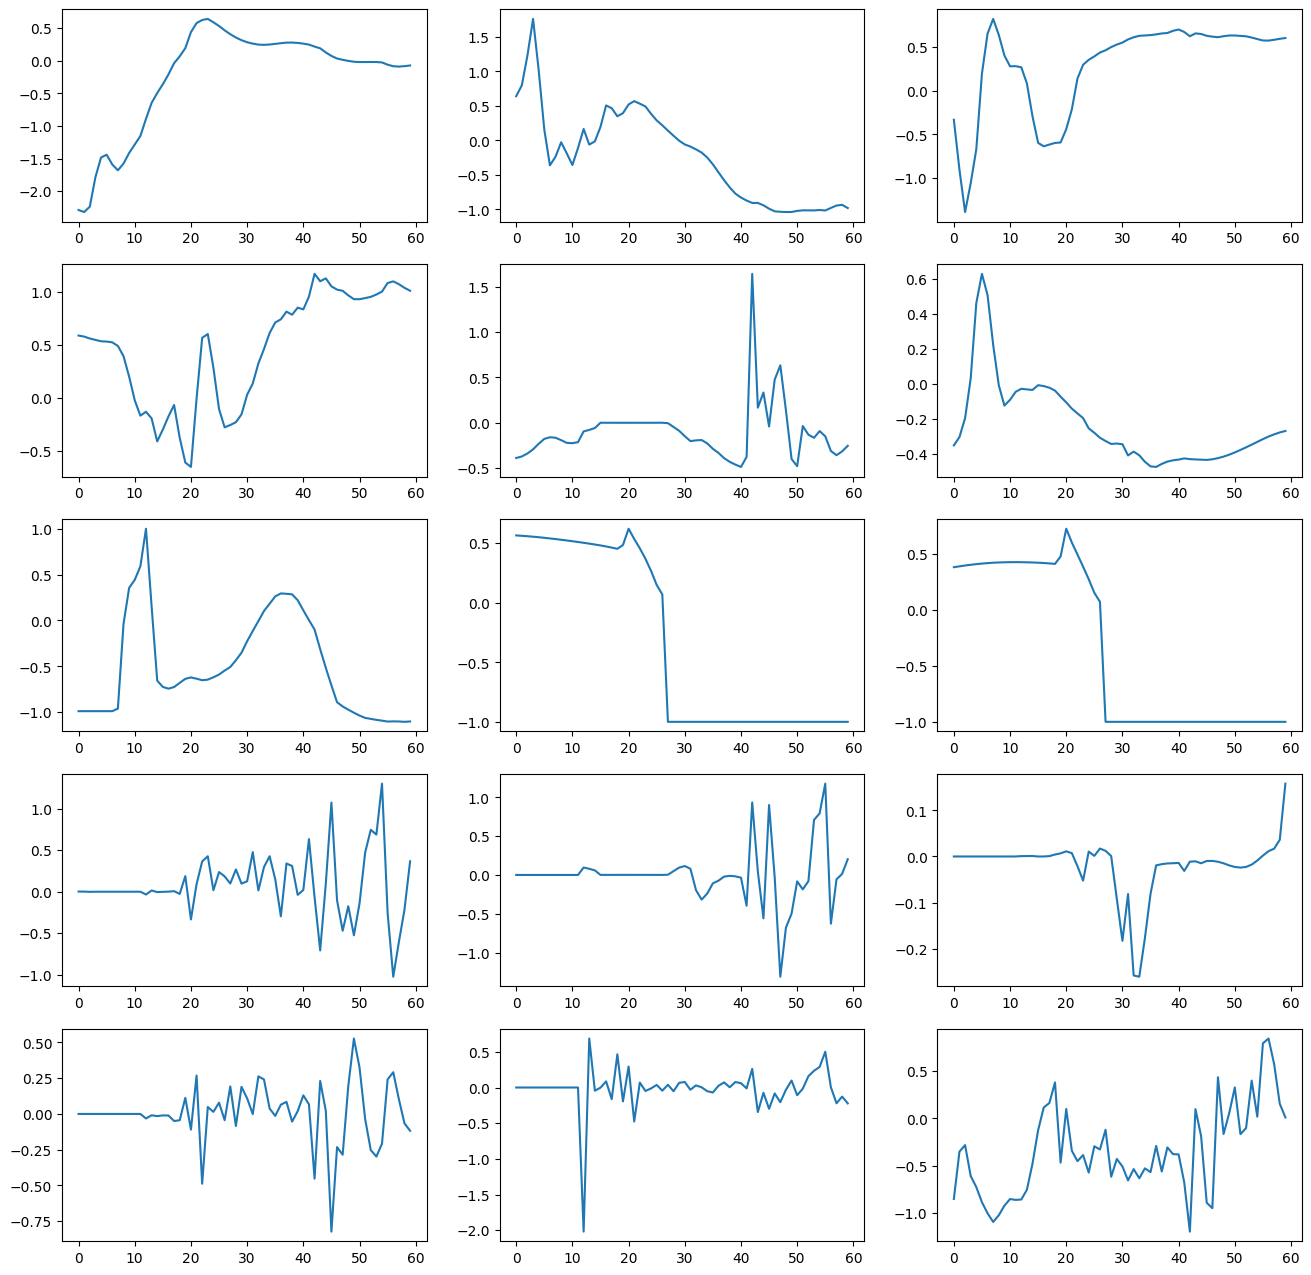

In [55]:
X_point, y_point = X[8], y[8] # nth data point from batch

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(16, 16))

axes[0, 0].plot(X_point[STATE_U_IDX])
axes[0, 1].plot(X_point[STATE_V_IDX])
axes[0, 2].plot(X_point[STATE_T_IDX])

axes[1, 0].plot(X_point[STATE_Q0001_IDX])
axes[1, 1].plot(X_point[STATE_Q0002_IDX])
axes[1, 2].plot(X_point[STATE_Q0003_IDX])

axes[2, 0].plot(X_point[PBUF_OZONE_IDX])
axes[2, 1].plot(X_point[PBUF_CH4_IDX])
axes[2, 2].plot(X_point[PBUF_N2O_IDX])

axes[3, 0].plot(y_point[PTEND_Q0001_IDX])
axes[3, 1].plot(y_point[PTEND_Q0002_IDX])
axes[3, 2].plot(y_point[PTEND_Q0003_IDX])

axes[4, 0].plot(y_point[PTEND_U_IDX])
axes[4, 1].plot(y_point[PTEND_V_IDX])
axes[4, 2].plot(y_point[PTEND_T_IDX])

plt.show()

### Training

In [56]:
LOSS_SCALE_TORCH = torch.tensor(LOSS_SCALE, dtype = torch.float64).to(DEVICE) * torch.tensor(TARGET_WEIGHTS, dtype = torch.float64).to(DEVICE)

LOSS_SCALE_TORCH[[-1,-2,-3,-4,-7,-8]] = 0.99 # CAM Values HAS TOO big MSE

In [57]:
def WeightedMSE(y_pred, y):
    return (LOSS_SCALE_TORCH**2 * (y - y_pred) ** 2)

In [58]:
def WeightedRMSE(y_pred, y):
    return (LOSS_SCALE_TORCH * torch.sqrt((y - y_pred) ** 2 + 1e-25))

In [59]:
def WeightedHUBER(y_pred, y):
    return LOSS_SCALE_TORCH * torch.nn.HuberLoss(reduction='none', delta=1.5)(y_pred, y)

In [60]:
a = torch.rand([2000, 368]).to(DEVICE)
b = torch.rand([2000, 368]).to(DEVICE)
print(WeightedMSE(a, b).mean())
print(WeightedMSE(a, b).mean(0).sum()/a.shape[-1])

tensor(0.1324, device='cuda:0', dtype=torch.float64)
tensor(0.1324, device='cuda:0', dtype=torch.float64)


In [61]:
#model = LeapModel(**nn_config)
model = TfaLeapModel(**nn_config_tfa)
model = model.to(DEVICE)
#model.load_state_dict(torch.load("best_score_model.pth", map_location=DEVICE), strict = True)
model.load_state_dict(torch.load("models/Huber_fast_LN_60_192_huber3/best_score_model_50ep_0.763.pth", map_location=DEVICE), strict = False)


criterion = nn.MSELoss()
criterion = WeightedMSE
criterion = WeightedRMSE
criterion = WeightedHUBER
#criterion = torch.nn.HuberLoss(reduction='mean', delta=3.0)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = lr_scheduler.PolynomialLR(optimizer, power=1.4, total_iters=NUM_EPOCHS)

In [62]:
scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=NUM_EPOCHS,
            T_mult=1,
            eta_min=1e-7,
            last_epoch=-1
        )

In [63]:
# lrs = []
# for i in range(NUM_EPOCHS):
#     scheduler.step(i)
#     lrs.append(scheduler.get_lr())

In [64]:
#plt.plot(list(range(NUM_EPOCHS)), lrs)

In [65]:
def reload_train_set(epoch):
    paths = [
        'dataset_f16_3.33_sample_1.parquet',
        'dataset_f16_3.33_sample_2.parquet',
        'dataset_f16_3.33_sample_3.parquet',
        'dataset_f16_year_8.parquet'
    ]

    path = paths[epoch%4]
    
    ds_train = LeapDataset(
        file_path=path,
        x_features=FEATURE_NAMES, 
        y_features=TARGET_NAMES,
        y_weights=torch.tensor(SCALE_WEIGHTS, dtype = torch.float64)
    )
    
    train_loader = DataLoader(
        ds_train, 
        batch_size=BATCH_SIZE, 
        shuffle=True, 
        drop_last=True,
    )

    return train_loader

In [66]:
scores = []
mses = []
r2s = []
r2s_detailed = []
train_mse = []

In [67]:
best_score = -np.inf
best_mse = np.inf


for epoch in range(0, NUM_EPOCHS):
    train_loss = train_fn(model, train_loader, optimizer, criterion)
    val_score, val_mse, val_r2_full, val_r2_detailed = valid_fn(model, valid_loader)

    train_mse.append(train_loss)
    scores.append(val_score)
    mses.append(val_mse)   
    r2s.append(val_r2_full)   
    r2s_detailed.append(val_r2_detailed)
    
    if val_r2_full > best_score:
        best_score = val_r2_full
        torch.save(model.state_dict(), "best_score_model.pth")

    if val_mse < best_mse:
        best_mse = val_mse
        torch.save(model.state_dict(), "best_mse_model.pth")
        
    torch.save(model.state_dict(), "last_model.pth")

    del train_loader
    train_loader = reload_train_set(epoch)
    
    scheduler.step()

Epoch 19: 100%|████████| 1270/1270 [02:21<00:00,  8.97it/s, val_sc=0.982, val_mse=0.3, val_r2=0.756]


In [68]:
history = pd.DataFrame({'train_loss': train_mse, 'mse': mses, 'r2': r2s})

<Axes: >

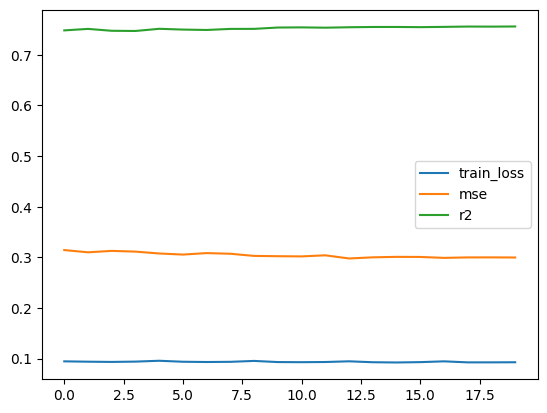

In [69]:
history.plot()

In [70]:
#val_score, val_mse, val_r2_full = valid_fn(model, valid_loader)

In [71]:
#torch.save(model.state_dict(), "last_model.pth")

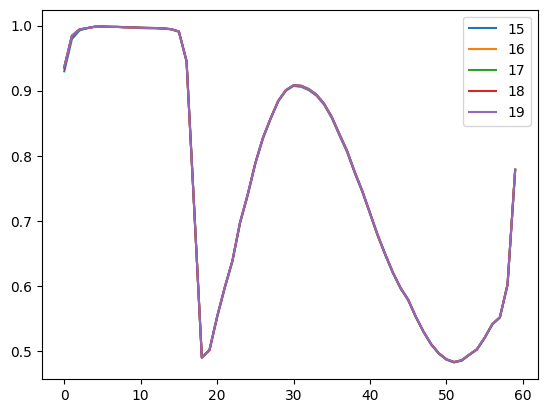

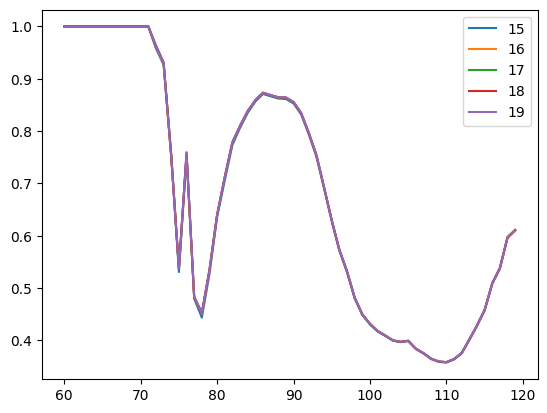

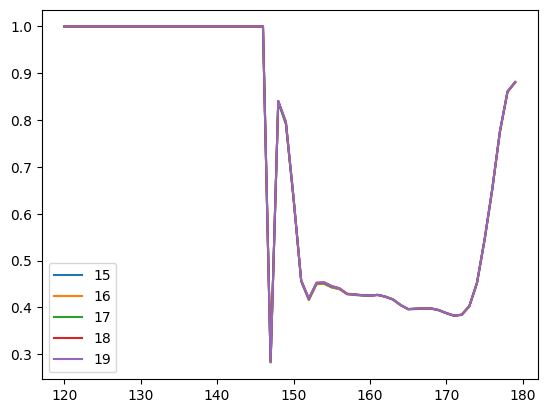

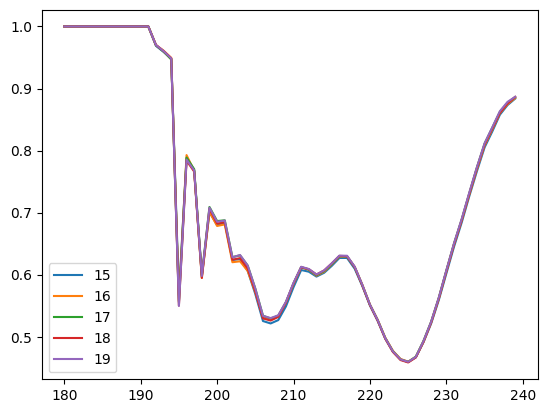

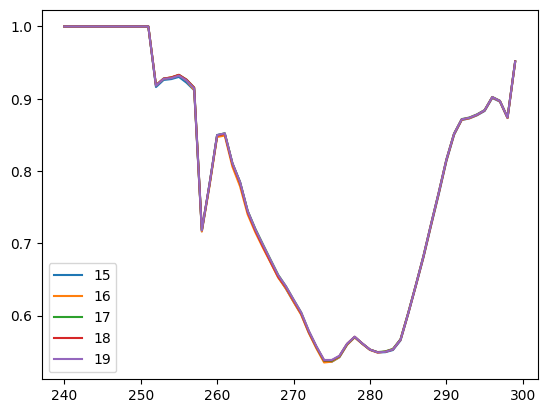

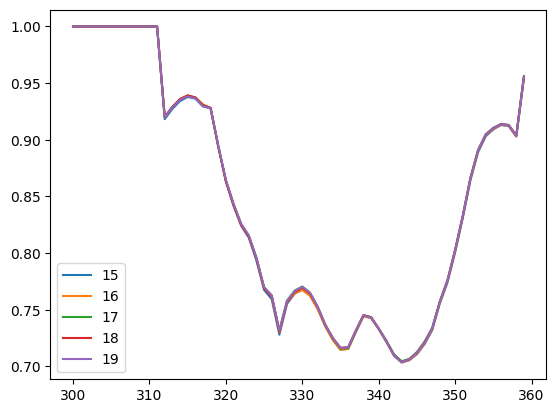

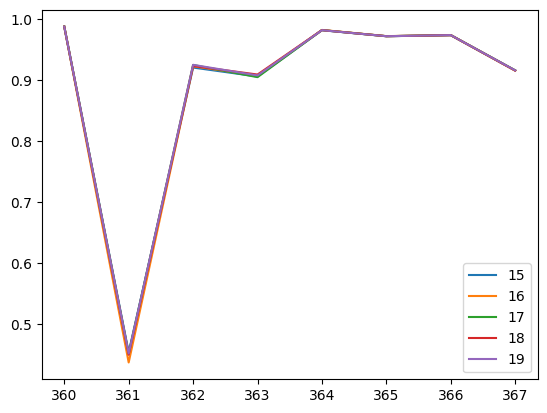

In [72]:
for ids in [PTEND_T_IDX, PTEND_Q0001_IDX, PTEND_Q0002_IDX, PTEND_Q0003_IDX, PTEND_U_IDX, PTEND_V_IDX, list(range(360, 368))]:
    pd.DataFrame(r2s_detailed).tail(5)[ids].T.plot()
    plt.show()


In [73]:
#torch.cuda.empty_cache()

In [74]:
f'{scheduler.get_last_lr()[0]:.6f}'

'0.000030'

# Pred val set

In [75]:
model = TfaLeapModel(**nn_config_tfa)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_score_model.pth", map_location=DEVICE))

<All keys matched successfully>

In [76]:
def predict_valid(model: nn.Module, loader: DataLoader) -> float:
    """
    Validate the deep learning model for 1 epoch.
    
    Parameters
    ----------
    model : torch.nn.Module
        The PyTorch model to be validated.
    loader : torch.utils.data.DataLoader
        DataLoader for the validation data.

    Returns
    -------
    float
        The average R2 score over the validation epoch.
    """
    
    progress_bar = tqdm(enumerate(loader, start=1), total=len(loader), ncols=100)
    #progress_bar.set_description(f'Epoch {epoch}')
    model.eval()
    val_score = 0
    preds = []
    
    with torch.no_grad():
        for step, batch in progress_bar:
            x, y, l = batch
            x, y = x.to(DEVICE), y.to(DEVICE)
            
            y_pred = model(x)
            
            y = y.cpu()
            y = (y * Y_STD) + Y_MEAN
            #y = (y * Y_STD)
            y /= torch.tensor(SCALE_WEIGHTS)

            
            y_pred = y_pred.cpu()
            #y_pred[:, Y_STD == 0] = Y_MEAN[:, Y_STD == 0]
            #y_pred[:, Y_STD < (1.1 * ERR)] = Y_MEAN[Y_STD < (1.1 * ERR)]
            
            y_pred = (y_pred * Y_STD) + Y_MEAN
            #y_pred = (y_pred * Y_STD) 
            y_pred /= torch.tensor(SCALE_WEIGHTS)

            
            val_score += r2_score(y_pred, y)
            
            progress_bar.set_postfix({
                'valid_score': val_score / step,
            })
        
            preds.append(y_pred.numpy())
    return np.vstack(preds)

In [77]:
#y_valid = np.concatenate([((yb * Y_STD))/torch.tensor(SCALE_WEIGHTS) for _, yb in valid_loader])
y_valid = np.concatenate([((yb * Y_STD) + Y_MEAN)/torch.tensor(SCALE_WEIGHTS) for _, yb, _ in valid_loader])
#y_valid = np.concatenate([((yb * Y_STD) + Y_MEAN) for _, yb in valid_loader])
#x_valid = np.concatenate([xb for xb, _ in valid_loader])
p_valid = predict_valid(model, valid_loader)

100%|████████████████████████████████████████| 1270/1270 [02:14<00:00,  9.47it/s, valid_score=0.982]


In [78]:
(~np.isfinite(y_valid)).sum()

0

In [79]:
#y_valid = np.concatenate([yb  for _, yb, _ in valid_loader])

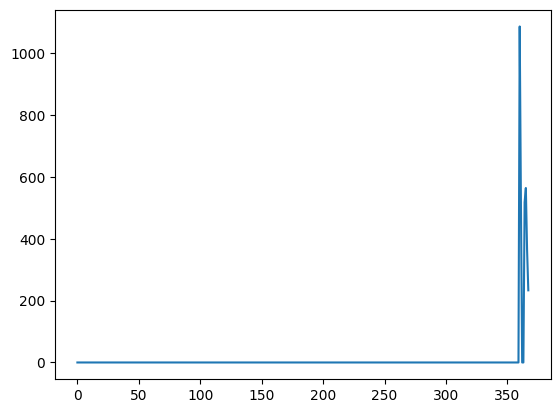

In [80]:
plt.plot(y_valid.max(0)[:368])

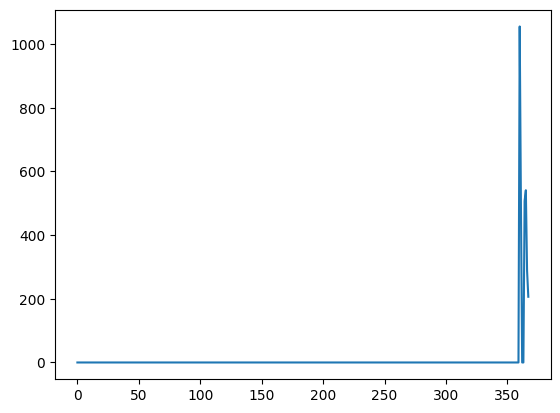

In [81]:
plt.plot(np.quantile(y_valid, 0.9999, axis=0))

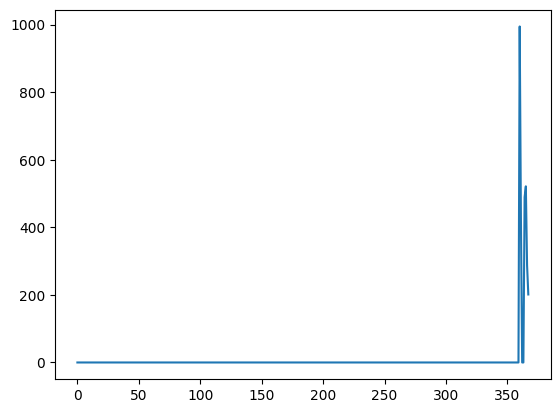

In [82]:
plt.plot(p_valid.max(0)[:368])

In [83]:
y_valid.max(0)

array([ 5.63427664e-03,  1.57898296e-03,  1.03412895e-03,  1.40288331e-04,
        1.91958979e-04,  2.40639580e-04,  2.59947626e-04,  2.31054931e-04,
        1.51046513e-04,  1.27035072e-04,  9.81898718e-05,  7.10286409e-05,
        5.35333039e-05,  3.63627973e-05,  2.73178660e-05,  2.30011230e-05,
        3.29220426e-04,  9.02207411e-04,  4.44564343e-04,  1.08002049e-03,
        7.13766784e-04,  9.62134431e-04,  1.06172253e-03,  1.14372249e-03,
        7.43492397e-04,  9.17048972e-04,  1.00091328e-03,  1.11190059e-03,
        1.05597612e-03,  1.10443335e-03,  1.27480935e-03,  1.36090825e-03,
        1.33705752e-03,  1.55939867e-03,  1.29753928e-03,  1.24616193e-03,
        1.26015349e-03,  1.10093577e-03,  9.49323246e-04,  1.09549852e-03,
        1.02986332e-03,  1.20215377e-03,  8.47299357e-04,  9.84668978e-04,
        8.82334128e-04,  7.97457563e-04,  8.90678802e-04,  8.74355979e-04,
        9.16766010e-04,  8.73724568e-04,  8.05812841e-04,  8.36919927e-04,
        1.06701183e-03,  

In [84]:
p_valid.max(0)

array([ 1.76300146e-03,  1.38257071e-03,  4.89332732e-04,  1.33756214e-04,
        1.83205600e-04,  2.22198204e-04,  2.34078825e-04,  2.15617194e-04,
        1.38959131e-04,  1.14135971e-04,  8.78654113e-05,  6.29828910e-05,
        4.68386385e-05,  3.43807614e-05,  2.46175816e-05,  2.01575526e-05,
        1.16206489e-04,  3.33229625e-04,  2.31266566e-04,  4.36622438e-04,
        4.35426734e-04,  4.67816678e-04,  6.39282829e-04,  7.70832645e-04,
        8.36291106e-04,  7.66749411e-04,  5.69192211e-04,  6.17656225e-04,
        6.55502070e-04,  8.59809473e-04,  1.08028261e-03,  1.22964492e-03,
        1.34254224e-03,  1.22280089e-03,  1.03527731e-03,  9.01506771e-04,
        9.19598950e-04,  8.70463808e-04,  7.52910554e-04,  6.49025978e-04,
        6.41784509e-04,  5.99538310e-04,  5.82746351e-04,  5.91356301e-04,
        4.85392613e-04,  5.40871042e-04,  5.02762775e-04,  6.75320213e-04,
        6.23716353e-04,  5.90749143e-04,  6.72092907e-04,  6.22991069e-04,
        4.21474560e-04,  

In [85]:
Y_MEAN[359:]

array([0.00659128, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [86]:
(nn.MSELoss(reduction='none')(torch.tensor(p_valid), torch.tensor(y_valid)) * torch.tensor(TARGET_WEIGHTS)).sum(1).mean()

tensor(4376.1025, dtype=torch.float64)

In [87]:
r2_score_clipped(torch.tensor(p_valid), torch.tensor(y_valid))

0.7559734150711676

In [88]:
errors = (((p_valid - y_valid)**2)**0.5/368).sum(1)
top_mistakes = (-errors).argsort()

errors[top_mistakes]

array([1.79675103e+00, 1.75337210e+00, 1.71881753e+00, ...,
       5.95178250e-06, 5.12498110e-06, 4.92841928e-06])

In [89]:
mask_errors = errors[top_mistakes] > 1.0
mask_errors.sum()

484

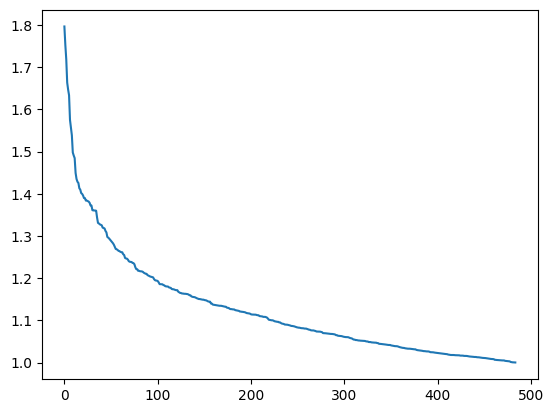

In [90]:
plt.plot(errors[top_mistakes][mask_errors])

0.6935092721712958

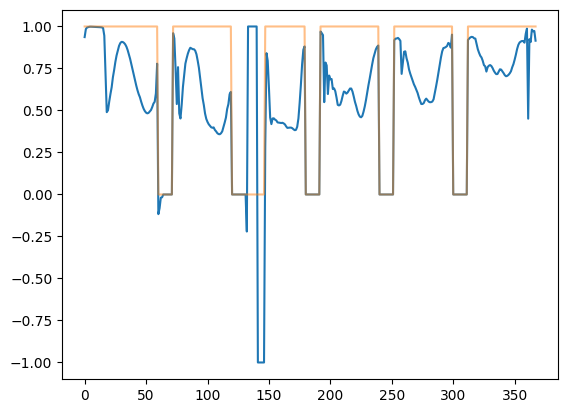

In [91]:


scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_valid[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [92]:
scores_valid

array([ 9.36761481e-01,  9.84804625e-01,  9.94188394e-01,  9.96234854e-01,
        9.98357862e-01,  9.98609493e-01,  9.98140419e-01,  9.97979013e-01,
        9.97480456e-01,  9.97057224e-01,  9.96637400e-01,  9.96376239e-01,
        9.96196493e-01,  9.95584336e-01,  9.94571098e-01,  9.90802500e-01,
        9.45280729e-01,  7.19366602e-01,  4.89953699e-01,  5.01195403e-01,
        5.52630879e-01,  5.97769479e-01,  6.38539815e-01,  6.97793893e-01,
        7.40493754e-01,  7.88931177e-01,  8.27884876e-01,  8.57389741e-01,
        8.84516955e-01,  9.00914707e-01,  9.08358630e-01,  9.07610966e-01,
        9.02523581e-01,  8.93871683e-01,  8.79897386e-01,  8.59679593e-01,
        8.33272184e-01,  8.07719374e-01,  7.75284383e-01,  7.45685121e-01,
        7.12249561e-01,  6.78429783e-01,  6.48505903e-01,  6.20520643e-01,
        5.96890094e-01,  5.78690369e-01,  5.52590101e-01,  5.29754642e-01,
        5.10398429e-01,  4.96428465e-01,  4.87064366e-01,  4.82830399e-01,
        4.85526519e-01,  

0.9464034436574752

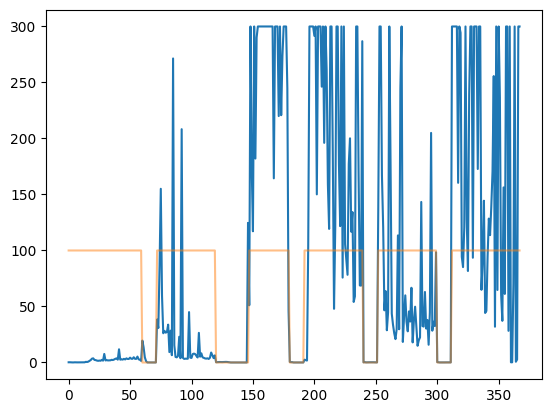

In [93]:
scores_valid = np.array([metrics.mean_absolute_percentage_error(y_valid[:, i], p_valid[:, i]) for i in range(368)]) 
plt.plot(scores_valid.clip(0, 300))
plt.plot(np.array(TARGET_WEIGHTS)*100, alpha = 0.5)
(scores_valid.clip(-1, 1) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [94]:
y_valid_scale = (y_valid - Y_MEAN) / Y_STD
p_valid_scale = (p_valid - Y_MEAN) / Y_STD

In [95]:
y_valid_scale.min(0)

array([-3.09338944e-01,  1.47749275e-01,  5.76607280e-02,  4.52505053e-02,
        3.93709719e-02,  1.99663967e-02,  2.84736212e-03, -5.26688741e-03,
       -3.87348723e-03,  1.98988244e-04, -4.70769656e-03, -8.23672082e-03,
       -1.76889326e-02, -2.98314727e-02, -6.08906275e-02, -1.25696759e-01,
       -2.49440221e-01, -2.12481451e-01, -8.56690307e-02,  2.21027495e-02,
        1.65832020e-02,  1.44828263e-01,  2.22584165e-01,  2.66275047e-01,
        2.70599107e-01,  2.33744218e-01,  1.78375847e-01,  1.22219737e-01,
        8.18136926e-02,  5.15652563e-02,  3.02484053e-02,  1.47753264e-02,
        3.44626292e-03, -3.96676311e-03, -8.49358287e-03, -1.08329031e-02,
       -1.16931484e-02, -1.20391503e-02, -1.19499195e-02, -1.05366465e-02,
       -8.37846282e-03, -5.14774834e-03, -3.06419734e-04,  5.44301059e-03,
        1.05342130e-02,  1.02886655e-02,  2.13135735e-03, -1.20474558e-02,
       -2.76408613e-02, -4.23786416e-02, -5.55061881e-02, -6.88016584e-02,
       -8.22242335e-02, -

In [96]:
y_valid_scale[:,-8:].min(0)

array([  0.        , 167.11424987,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [97]:
(y_valid_scale[:,-1:] < -0.4992).sum()

0

In [98]:
y_valid_scale.shape

(325000, 368)

2.7211263124946994

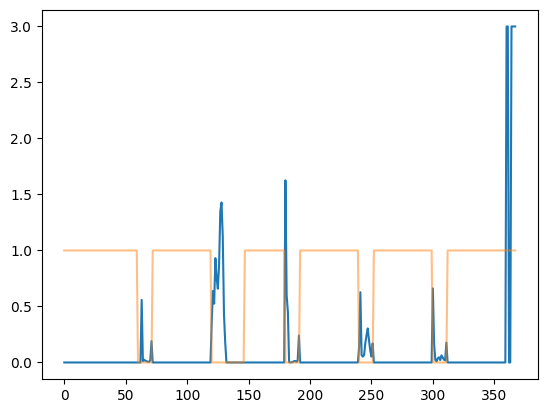

In [99]:
mse_valid = nn.MSELoss(reduction='none')(torch.tensor(y_valid_scale), torch.tensor(p_valid_scale)).mean(0).numpy()

plt.plot(mse_valid.clip(0, 3))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
(scores_valid.clip(0, 3) * np.array(TARGET_WEIGHTS)).sum() / np.array(TARGET_WEIGHTS).sum()

In [100]:
mse_valid

array([6.20058797e-10, 1.35873687e-10, 5.69187579e-11, 3.74777559e-11,
       1.63668353e-11, 1.38716126e-11, 1.85478317e-11, 2.01457921e-11,
       2.51016659e-11, 2.93312572e-11, 3.35236413e-13, 3.61479414e-13,
       3.79535252e-13, 4.40122696e-13, 5.39533113e-13, 9.00906700e-13,
       5.03078651e-12, 2.33566078e-09, 5.12690703e-09, 4.86506698e-09,
       4.31924069e-09, 3.81238225e-09, 3.26496194e-09, 2.61725887e-09,
       2.25774666e-09, 1.90478559e-09, 1.61881346e-09, 1.37634548e-09,
       1.14020625e-09, 9.90999670e-10, 9.21481094e-10, 9.29425271e-10,
       9.88946158e-10, 1.07088184e-09, 1.19619038e-09, 1.39790372e-09,
       1.66323302e-09, 1.92491053e-09, 2.22253407e-09, 2.51446574e-09,
       2.85908785e-09, 3.18596307e-09, 3.49152148e-09, 3.76056279e-09,
       4.01227238e-09, 4.21015015e-09, 4.44637438e-09, 4.68427582e-09,
       4.87712205e-09, 5.04339239e-09, 5.09330263e-09, 5.11885759e-09,
       5.07362741e-09, 4.98774726e-09, 4.89540670e-09, 4.76867890e-09,
      

In [101]:
y_valid

array([[-9.44081483e-06, -2.50644278e-06, -2.58720172e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.61203395e-05, -4.67126841e-05, -9.15435839e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.16571401e-05, -3.25209923e-05, -4.73482895e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 4.48269726e-05,  1.08559358e-05,  3.53981434e-05, ...,
         1.85183659e+02,  8.18856443e+01,  5.66770722e+01],
       [-1.75528392e-05, -6.55792640e-06, -3.43511965e-05, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.29893508e-05,  1.25914523e-05,  6.14182201e-05, ...,
         1.29365889e+02,  3.55247406e+01,  3.42416945e+00]])

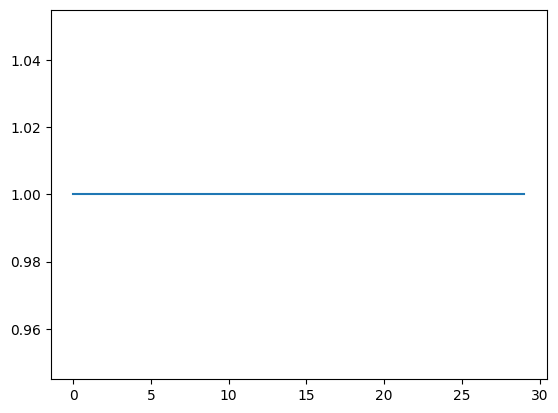

In [102]:
plt.plot(scores_valid.clip(-1, 1)[80:110])

In [103]:
Y_STD[70:110]

array([1.00000000e-16, 1.00000000e-16, 1.15259357e-01, 9.26646159e-02,
       6.83181510e-01, 2.82527620e-01, 2.85637499e-01, 2.16007027e-01,
       4.05532505e-01, 8.83984575e-02, 1.85894519e-01, 4.10275694e-02,
       8.89428372e-02, 1.74130821e-01, 3.06233711e-01, 4.88101169e-01,
       7.01888995e-02, 9.23739157e-02, 1.14478269e-01, 1.37504864e-01,
       1.59475037e-01, 1.77086630e-01, 1.91172754e-01, 2.03608761e-01,
       2.16769175e-01, 2.33311113e-01, 2.53095873e-01, 2.76469064e-01,
       3.03409231e-01, 3.35553072e-01, 3.71215568e-01, 4.10011741e-01,
       4.49273877e-01, 4.86716026e-01, 5.20505820e-01, 5.50603625e-01,
       5.71668172e-01, 5.82665813e-01, 5.88294881e-01, 5.88565213e-01])

In [104]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0][Y_STD[np.array(TARGET_WEIGHTS)>0] == 0]

array([], dtype=float64)

In [105]:
scores_valid[Y_MEAN==0]

array([3.68865315e-02, 5.48844082e-02, 5.05524488e-02, 4.24145347e-02,
       3.43998698e-02, 2.81657919e-02, 2.76510814e-02, 2.69185768e-02,
       2.52641018e-01, 3.24945555e-01, 2.99631782e-01, 4.20352092e-01,
       3.79244924e-01, 3.53774111e-01, 4.10726864e-01, 5.06954778e-01,
       5.20423679e-01, 4.60053278e-01, 2.79800183e-01, 1.55350461e-01,
       5.60154966e-01, 3.11460346e-01, 2.73629937e-01, 1.15474368e-02,
       8.21257038e-03, 1.20695612e-02, 1.94046003e-02, 2.27501299e-02,
       1.98999328e-02, 1.28036878e-02, 1.10854915e-02, 1.08010154e-02,
       1.30453580e-01, 3.22330964e-01, 9.47555620e-02, 9.51158645e-02,
       1.10918141e-01, 1.81339956e-01, 2.09717049e-01, 2.29519847e-01,
       1.92151300e-01, 1.41449780e-01, 9.33280692e-02, 7.29356648e-02,
       3.56405874e-01, 1.69604693e-01, 5.16940423e-02, 3.51489243e-02,
       7.29977679e-02, 8.73154628e-02, 5.83920486e-02, 1.09239949e-01,
       9.01048726e-02, 6.67180204e-02, 4.72935906e-02, 8.22906689e-02,
      

In [106]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [107]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [108]:
Y_MEAN

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [109]:
import math

S_WEIGHTS = []

for val in Y_MEAN:
    if val != 0:
        logval = math.log10(abs(val))
        S_WEIGHTS.append(-round(logval - (0.5 if logval<0 else 0)))
    else:
        S_WEIGHTS.append(0)


S_WEIGHTS = [float(f'1e{f}') for f in S_WEIGHTS]

In [110]:
print(S_WEIGHTS)

[10.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 10000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 10.0, 100.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 10000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 10.0, 10.0, 10000.0, 10000.0, 10000.0, 1e+19, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10000.0, 10000.0, 1000.0, 10000.0, 10000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 1000.0, 1000.0, 1000.0, 100.0, 100.0, 100.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1000.0, 1000.0, 1000.0, 100.0, 0.0001, 0.0001, 0.001, 0.01, 0.01, 0.01, 0

In [111]:
round(logval - (0.5 if logval<0 else 0))

-3

In [112]:
S_WEIGHTS = []

for yy in Y_MEAN:
    T = 1
    if abs(yy) > 1:
        T = 1   
    elif abs(yy) > 1e-6:
        T = 1e6
    elif abs(yy) > 1e-10:
        T = 1e10    
    elif abs(yy) > 1e-16:
        T = 1e16            
    elif abs(yy) > 1e-20:
        T = 1e20        
    elif abs(yy) > 1e-24:
        T = 1e24        
    elif abs(yy) > 1e-30:
        T = 1e30
    elif abs(yy) > 1e-36:
        T = 1e36
    elif abs(yy) <= 1e-36:
        T = 1e36
    S_WEIGHTS.append(T)
                    

In [113]:
print(S_WEIGHTS)

[1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1e+20, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1e+36, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1000000.0, 1

In [114]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0][Y_STD[np.array(TARGET_WEIGHTS)>0] == ERR]

array([], dtype=float64)

In [115]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [116]:
Y_MEAN[np.array(TARGET_WEIGHTS)>0]

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [117]:
[Y_STD[np.array(TARGET_WEIGHTS)>0] == ERR]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
      

In [118]:
np.log(6.8322e-37)

-83.27400171071722

In [119]:
Y_MEAN

array([ 1.02929261e-01, -6.97155326e-02, -3.15299507e-02, -3.19619268e-02,
       -3.63129338e-02, -2.22857484e-02, -3.13506470e-03,  3.97841919e-03,
        1.83784833e-03, -1.60611399e-04,  1.38263980e-02,  1.86093024e-02,
        2.95191264e-02,  3.75109372e-02,  5.67370059e-02,  9.31576893e-02,
        1.72058030e-01,  1.65372095e-02,  7.61109410e-03, -3.89531922e-03,
       -3.52564088e-03, -2.38466249e-02, -4.12396960e-02, -5.64972054e-02,
       -6.61519066e-02, -6.61819628e-02, -5.81682309e-02, -4.68412721e-02,
       -3.57749574e-02, -2.57151994e-02, -1.68952969e-02, -9.05130939e-03,
       -2.76688278e-03,  1.91246591e-03,  4.85856089e-03,  6.51845951e-03,
        6.98788417e-03,  7.02315626e-03,  6.87885541e-03,  6.06122679e-03,
        4.62000010e-03,  2.56066947e-03, -3.63076626e-04, -3.85495130e-03,
       -6.96830829e-03, -6.93094346e-03, -1.90584647e-03,  6.68160697e-03,
        1.57043694e-02,  2.37879026e-02,  3.05528183e-02,  3.68716334e-02,
        4.26353070e-02,  

In [120]:
np.finfo(np.float32)

finfo(resolution=1e-06, min=-3.4028235e+38, max=3.4028235e+38, dtype=float32)

In [121]:
Y_STD[np.array(TARGET_WEIGHTS)>0]

array([0.33904951, 0.44991617, 0.53023997, 0.68980353, 0.91454082,
       1.10335843, 1.03457842, 0.78783475, 0.50254858, 0.38697311,
       2.94961358, 2.26554557, 1.67123934, 1.25858581, 0.93235221,
       0.7419309 , 0.69083685, 0.07965096, 0.1094122 , 0.13763185,
       0.15043989, 0.16075318, 0.18151723, 0.21005089, 0.24184829,
       0.27910623, 0.323123  , 0.37492876, 0.43054877, 0.48962206,
       0.54427667, 0.58454766, 0.61222739, 0.63077924, 0.64200634,
       0.64544652, 0.64074007, 0.63322789, 0.62622654, 0.62011605,
       0.61514178, 0.61097262, 0.61000543, 0.61266751, 0.61629205,
       0.61767403, 0.61208417, 0.60092445, 0.58837284, 0.57431648,
       0.55935203, 0.54387452, 0.52725497, 0.50966103, 0.49168715,
       0.47748374, 0.47209206, 0.48213407, 0.57320541, 0.95958514,
       0.11525936, 0.09266462, 0.68318151, 0.28252762, 0.2856375 ,
       0.21600703, 0.4055325 , 0.08839846, 0.18589452, 0.04102757,
       0.08894284, 0.17413082, 0.30623371, 0.48810117, 0.07018

In [122]:
mask = scores_valid <= 1e-3

p_test = np.array(p_valid)
p_test[:, mask] = Y_MEAN[mask]

0.5325087294397715

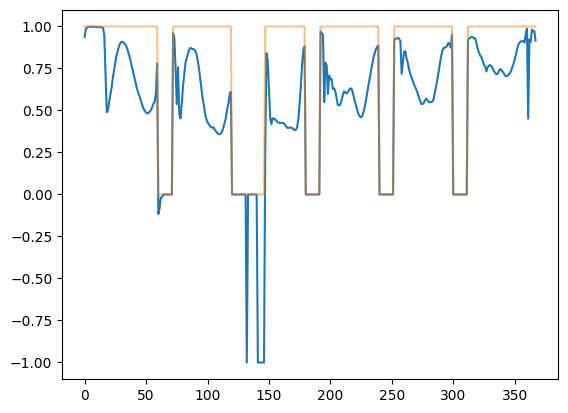

In [123]:
scores_valid = np.array([metrics.r2_score(y_valid[:, i], p_test[:, i]) for i in range(368)])
plt.plot(scores_valid.clip(-1, 1))
plt.plot(TARGET_WEIGHTS, alpha = 0.5)
scores_valid.clip(-1, 1).mean()

### Evaluation

In [124]:
model = LeapModel(**nn_config)
model = model.to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
#model.load_state_dict(torch.load("/kaggle/input/leap-models/first_leap_model.pth", map_location=DEVICE))

df_test = pl.read_csv(TEST_PATH)
df_test = df_test.to_pandas()
df_test = df_test.set_index("sample_id")

df_subm = pl.read_csv(SUBMISSION_PATH)
df_subm = df_subm.to_pandas()
df_subm = df_subm.set_index("sample_id")

static_pred = -df_test[REPLACE_TO].to_numpy() * df_subm[REPLACE_FROM].to_numpy() / 1200

NameError: name 'LeapModel' is not defined

In [ ]:
df_subm.loc[df_test.index, TARGET_NAMES] = pred_fn(model, df_test)

df_subm[REPLACE_FROM] = static_pred

df_subm = df_subm.reset_index()
df_subm = df_subm[["sample_id"] + TARGET_NAMES]

df_subm = pl.from_pandas(df_subm)
df_subm.write_csv("submission.csv")

In [ ]:
import pandas as pd

df = pd.concat([
    pd.read_parquet('dataset_f16_10kk_part_1.parquet', columns = TARGET_NAMES + ['sample_id']),
    pd.read_parquet('dataset_f16_10kk_part_2.parquet', columns = TARGET_NAMES + ['sample_id']),
    pd.read_parquet('dataset_f16_10kk_part_3.parquet', columns = TARGET_NAMES + ['sample_id']),
    pd.read_parquet('dataset_f16_10kk_part_4.parquet', columns = TARGET_NAMES + ['sample_id']),
])



In [ ]:
y_min = df.groupby(df.sample_id.map(lambda x: int(x.split('_')[-1])%384))[TARGET_NAMES].min(0)

In [ ]:
y_max = df.groupby(df.sample_id.map(lambda x: int(x.split('_')[-1])%384))[TARGET_NAMES].max(0)

In [ ]:
y_min

In [ ]:
LOC_Y_MIN

In [ ]:
import gc

del df
gc.collect()

In [ ]:
df = pd.concat([
    pd.read_parquet('dataset_f16_10kk_part_1.parquet').sample(900_000),
    pd.read_parquet('dataset_f16_10kk_part_2.parquet').sample(900_000),
    pd.read_parquet('dataset_f16_10kk_part_3.parquet').sample(900_000),
    pd.read_parquet('dataset_f16_10kk_part_4.parquet').sample(900_000),
])

In [ ]:
df.to_parquet('dataset_f16_3.6m_sample.parquet', index=False)